# Statistics

Here, we perform various statistics.</br>
1. We check compare performance measures between the cross-sectional (C-Norms) and longitudinal normative models (B-Norms).
2. We perform association tests between deviation scores as obtained by the C/B-Norms with pubertal status (PDS scores)


In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.api as sm
import utils
import warnings


from statsmodels.formula.api import ols, glm
from statsmodels.stats.multitest import multipletests
from scikit_posthocs import posthoc_dunn
from functools import reduce
from nilearn import plotting, datasets
from tqdm import tqdm
from glob import glob
from statsmodels.graphics.factorplots import interaction_plot
from pingouin import rm_anova, pairwise_ttests, sphericity, normality

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

MODEL_IDS = ['CNorm', 'BNorm']
DS_IDS = ['male', 'female']
TIMEPOINTS = ['2yr', '4yr']


sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='helvetica',
    font_scale=1.5,
    color_codes=True,
    rc=None,
)

# colors we use throughout the paper
colors = sns.color_palette(palette=[[12/255, 123/255, 220/255], 
                                    [216/255, 27/255, 96/255]])

Let us setup some important variables.

In [2]:
proj_dir = '/Users/philis/Documents/projects/b-norm_modelling' # exchange this with your local path
os.chdir(proj_dir) # we want to make sure we're in the correct project directory 

atlas_to_use = 'glasser' # we currently just use the glasser atlas, if you have a different one, exchange.

# load the data
df_combined_2yr = pd.read_csv(f'data/{atlas_to_use}/combined_features_2yr.csv')
df_combined_4yr = pd.read_csv(f'data/{atlas_to_use}/combined_features_4yr.csv')

# just from the way our files are setup, we know that from column 15 to the end we have the ROI labels
# (this includes the lh/rh averages)
ROI_lbls = df_combined_2yr.columns[15:] 

# setup some paths we regularly use
model_out_dir = f'model_output/{atlas_to_use}/'
stats_out_dir = f'stats/{atlas_to_use}'; os.makedirs(stats_out_dir, exist_ok=True)
plot_out_dir = f'plots/{atlas_to_use}'; os.makedirs(plot_out_dir, exist_ok=True)
supp_plot_dir = os.path.join(plot_out_dir, 'supplements'); os.makedirs(supp_plot_dir, exist_ok=True)

for mID in MODEL_IDS:
    for ds in DS_IDS:
        os.makedirs(os.path.join(plot_out_dir, mID, ds), exist_ok=True)
        os.makedirs(os.path.join(stats_out_dir, mID, ds), exist_ok=True)

# Helper functions

Some useful functions that are just necessary in this notebook. </br>
They therefore won't appear in the utils python file. 

In [3]:
def load_lobe_data(new_label=None):
    '''
    This function ... TODO
    '''
    
    inter = []
    for hemi in ['LH', 'RH']:
        df = pd.read_csv(f'manuscript/colortab{hemi}_HCP.csv', delimiter=',')
        inter.append(df)

    df_lobe = pd.concat(inter)
    if new_label is not None:
        df_lobe.ROI = new_label

    return df_lobe

In [4]:
def get_puberty_categories(sex):
    ''' 
    This function simply extracts the pubertal categories at the BL, 2yr, and 4yr timepoints.
    '''
    
    df = pd.read_csv(f"data/test_{sex}_f2.csv", usecols=["PDS_category_bl", "PDS_category_2yr", "PDS_category_4yr"])
    return df[df.columns[[0,2,1]]] # for some reason 4yr is before 2yr. This rearranges it into the correct order

In [5]:
def load_performance_data(mIDs, datasets=['full', 'male', 'female'], timepoints=["2yr", "4yr"], suffix="w4yr", use_bspline=False):
    '''
    This function ... TODO
    '''
    
    dfs = []
    bspline_suffix = '_bspline' if use_bspline else ''
    for d, ds in enumerate(datasets):
        for j, mod in enumerate(mIDs):
            for t, tpt in enumerate(timepoints):
                try:
                    if ds == 'full':
                        inter = []
                        for s, sex in enumerate(["male", "female"]):
                            inter.append(pd.read_csv(os.path.join(f'model_output/{atlas_to_use}/', f"{mod}{bspline_suffix}", ds, 
                                                          f"{tpt}_performance_{suffix}.csv")))
                            inter[s]['sex'] = f"full_{sex}"
                        df = pd.concat(inter)
                    else: 
                        df = pd.read_csv(os.path.join(f'model_output/{atlas_to_use}/', f"{mod}{bspline_suffix}", ds, 
                                                      f"{tpt}_performance_{suffix}.csv"))
                        df['sex'] = ds
                    df['timepoint'] = tpt
                    df['dataset'] = ds
                    df['model'] = mod
                    dfs.append(df)
                except:
                    print(f"Warning: {tpt} does not exist for {ds} {mod}")
                    continue
    
    combined = pd.concat(dfs, axis=0).reset_index(drop=True)
    return combined

# Save Z-scores into file for later use

We save the z-scores as obtained by the models for the male and female data.
This makes it easier later to do statistics etc.

In [6]:
# load the z-scores for each ROI, check the percentage of how many are z<-2 or z>2
use_bspline = False
bspline_suffix = '_bspline' if use_bspline else ''

inter = pd.read_csv("data/test_full_f2.csv") # we need this variable to identify sex in the full-Model condtion

for m, mID in enumerate(MODEL_IDS): # C-Norm, B-Norm
    for ds in DS_IDS: # full, male, female
        df_zs, complete = [], []
        Zs = [{} for i in range(len(TIMEPOINTS))]
        
        for t, tpt in enumerate(TIMEPOINTS):
            for r, roi in enumerate(ROI_lbls): # 362 ROIs
                r_dir = os.path.join(model_out_dir, mID + bspline_suffix, ds, roi, f'evaluate_{tpt}', 'Z_predict.txt')
                Zs[t][roi] = np.loadtxt(r_dir)
                
            df_zs.append(pd.DataFrame(Zs[t]))
            df_zs[t]['sex'] = ds
            
            # in the full condition we should be able to separate by sex. We therefore need to add a sex identifier
            if ds == 'full':
                for s, sex in enumerate(DS_IDS):
                    idcs = inter[inter.sex_bl == s+1].index
                    df_zs[t].loc[idcs, 'sex'] = sex
                    
            df_zs[t]['timepoint'] = tpt
            df_zs[t]['model'] = mID
    
        complete.append(pd.concat(df_zs).reset_index(drop=True))
    
        all_z = pd.concat(complete)
        out_path = os.path.join(stats_out_dir, mID, ds); os.makedirs(out_path, exist_ok=True)
        all_z.to_csv(os.path.join(out_path, 'all_z.csv'), index=False)

# FIGURE/STATS #1 - Comparing performance measures between C/B-Norms

In this section, we plot and statistically compare performance measures between the cross-sectional and longitudinal normative models.

While the python toolbox provides us with an extensive list of measures (Rho, explained variance, root-mean squared error (RMSE), standardized mean squared error (SMSE), mean squared log loss (MSLL), and Bayesian Information Criteria (BIC), skewness, and kurtosis) we focus on Explained Variance, skewness and kurtosis. 

Rho and Explained Variance allow us to make inferences about the mean fit of the models, whereas skewness and kurtosis allow us to make inferences on the shapes of the distributions. 

In [7]:
# we load the data here
combined = load_performance_data(MODEL_IDS, datasets=DS_IDS, timepoints=TIMEPOINTS, suffix="w4yr", use_bspline=False)

# because we do not want the averages in our statistics, we remove them here and use this dataframe for our statistics and plotting.
# we still need the average rows to propperly plot on the surface using the glasser atlas. 
performances_wo_avg = combined.drop(index=combined[combined.ROI.str.find("avg") > 0].index).copy()
performances_wo_avg

ROI       MSLL        EV      SMSE      RMSE       Rho  \
1        lh_L_V1  -0.014291  0.191483  0.808519  0.109796  0.437939   
2       lh_L_MST   0.009943  0.019779  0.980800  0.173800  0.146246   
3        lh_L_V6   0.083594  0.042965  1.020238  0.139618  0.210023   
4        lh_L_V2   0.249516  0.080922  0.920032  0.113726  0.284508   
5        lh_L_V3  23.091854  0.059420  0.949303  0.114421  0.244602   
...          ...        ...       ...       ...       ...       ...   
2891  rh_R_STSva  73.265982  0.646680  0.375777  0.092592  0.804204   
2892   rh_R_TE1m  63.956875  0.738673  0.296734  0.115340  0.859461   
2893     rh_R_PI  27.555086  0.466674  0.534481  0.142764  0.684262   
2894  rh_R_a32pr  53.297545  0.626407  0.373853  0.106278  0.792549   
2895    rh_R_p24  45.610192  0.635744  0.372482  0.127960  0.798805   

              BIC      skew  kurtosis     sex timepoint dataset  model  
1    -4042.721160  0.294427  0.074290    male       2yr    male  CNorm  
2    -1372.778048  0.091409  0.184233    male       2yr    male  CNorm  
3    -2465.640501 -0.291509  0.299644    male       2yr    male  CNorm  
4    -4039.284966 -0.034054  0.097615    male       2yr    male  CNorm  
5    -3873.378362  0.215417  0.014330    male       2yr    male  CNorm  
...           ...       ...       ...     ...       ...     ...    ...  
2891 -4847.463692  0.170686  1.229777  female       4yr  female  BNorm  
2892 -3900.304795  1.022720  6.446300  female       4yr  female  BNorm  
2893 -2698.345474 -0.406843  2.643561  female       4yr  female  BNorm  
2894 -3725.720123 -0.155141  1.158275  female       4yr  female  BNorm  
2895 -2933.569073  0.136438  3.055413  female       4yr  female  BNorm  

[2880 rows x 13 columns]

## Comparing the Models

### Performance measures

#### Plots

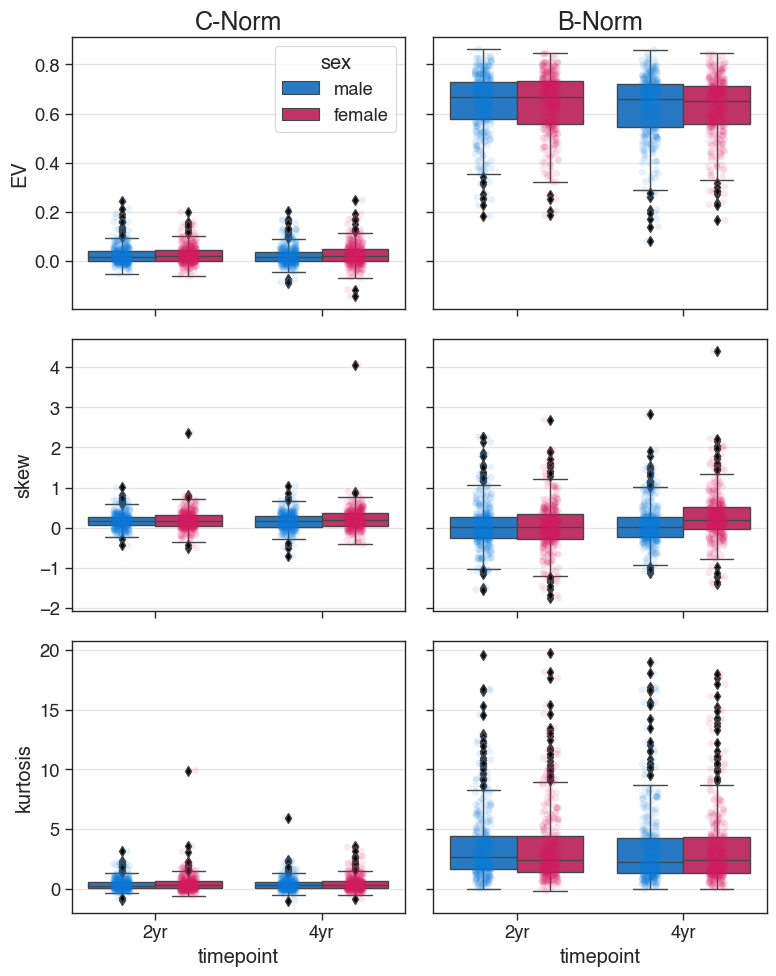

In [8]:
# plot performances for the sexspecific models
metrics = ['EV', 'skew', 'kurtosis']

# copy the data into a new dataframe
data = performances_wo_avg.copy()

# set up a figure with n-metrics by models (2)
# given the different value magnitudes, we share the y-axis across rows
fig, axes = plt.subplots(len(metrics), 2, figsize=(8, 10), sharex=True, sharey='row')

for m, metric in enumerate(metrics):
    for c, mID in enumerate(MODEL_IDS):
        # kurtosis is extremely sensitive to outliers. for visualization purposes we only retain values for kurtosis < 20.
        to_plot = data[data.model==mID] if metric != 'kurtosis' else data[(data.model==mID) & (data['kurtosis'] < 20)]
        
        sns.boxplot(ax=axes[m, c], data=to_plot, x='timepoint', y=metric, hue='sex', palette=colors, 
                    fliersize=5, flierprops={"marker": "d", "markerfacecolor": 'k'})
        sns.stripplot(ax=axes[m, c], data=to_plot, x='timepoint', y=metric, hue='sex', palette=colors, 
                      dodge=True, alpha=.1, legend=False) # we add individual dots to indicate dist.
        
        axes[0, c].set_title(mID.replace("Norm", "-Norm"), fontsize=18)
        axes[m, c].grid(visible=True, linewidth=1, alpha=.5, axis='y')
        if (m > 0) | (c > 0): # we only need the legend once.
            axes[m, c].legend_.remove()

fig.tight_layout()
plt.savefig(os.path.join(plot_out_dir, 'sexspecific_performances.pdf'), transparent=False, dpi=300)

This figure suggests marked differences in the mean fit between models (top row). B-Norms yielded much higher variance explained for both 2-year and 4-year follow up compared to C-Norms. The overall pattern was similar across sexes, with higher variance explained for B-Norms compared to C-Norms. On top of these large B-Norm-C-Norm differences, we observed a small MODELxTIMEPOINT interaction, indicating that the accuracy of mean fits decreased from 2-year to 4-year follow up, with largest effects in B-Norms and in males. 

For the shape of the distribution and the centiles of the predicted z-scores, we investigated skewness and excess kurtosis (i.e., kurtosis values below or greater than 0), where values close to zero would indicate a standard normal distribution. On average, we found that skewness was closer to zero for B-Norms than C-Norms, however, variance was larger in B-Norms indicating that there are regions where the shape distribution of the B-Norms were less perfect. For kurtosis we observed lower performance of the B-Norms compared to C-Norms. The lower panels in Figure 1A depict the distributions and the corresponding statistics from repeated measures Anova are detailed in the Supplement.

#### Sexspecific Statisticis

We then perform a 2-factor (model: C-Norm/B-Norm and timepoint: 2/4yr) repeated measure ANOVA for each of males anf females separately.

To have some more information, we also plot the different ANOVA plots.

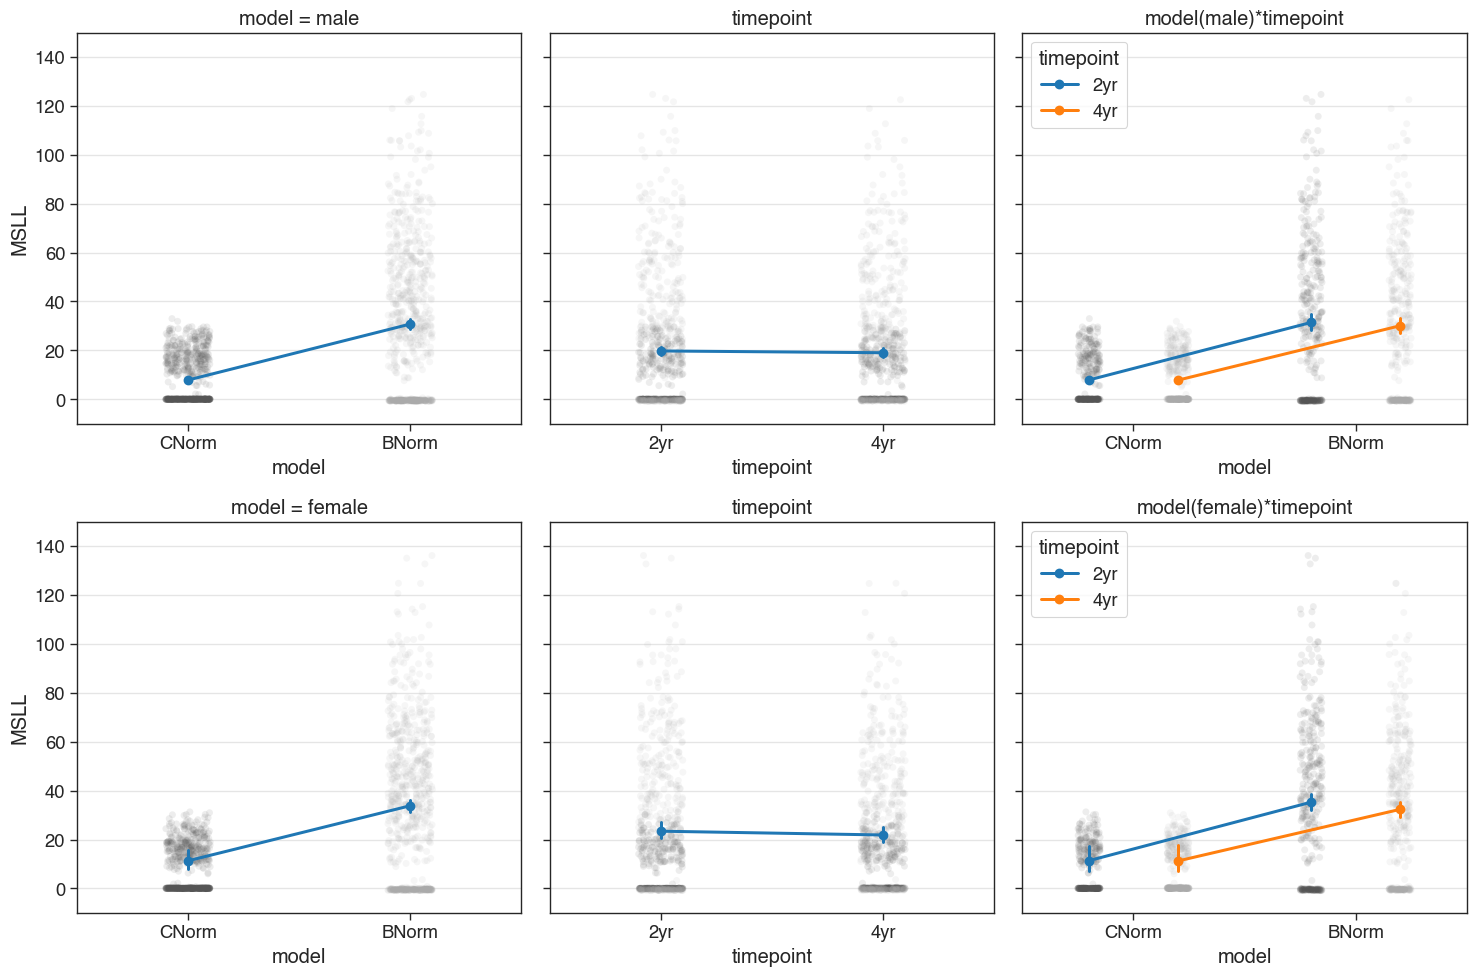

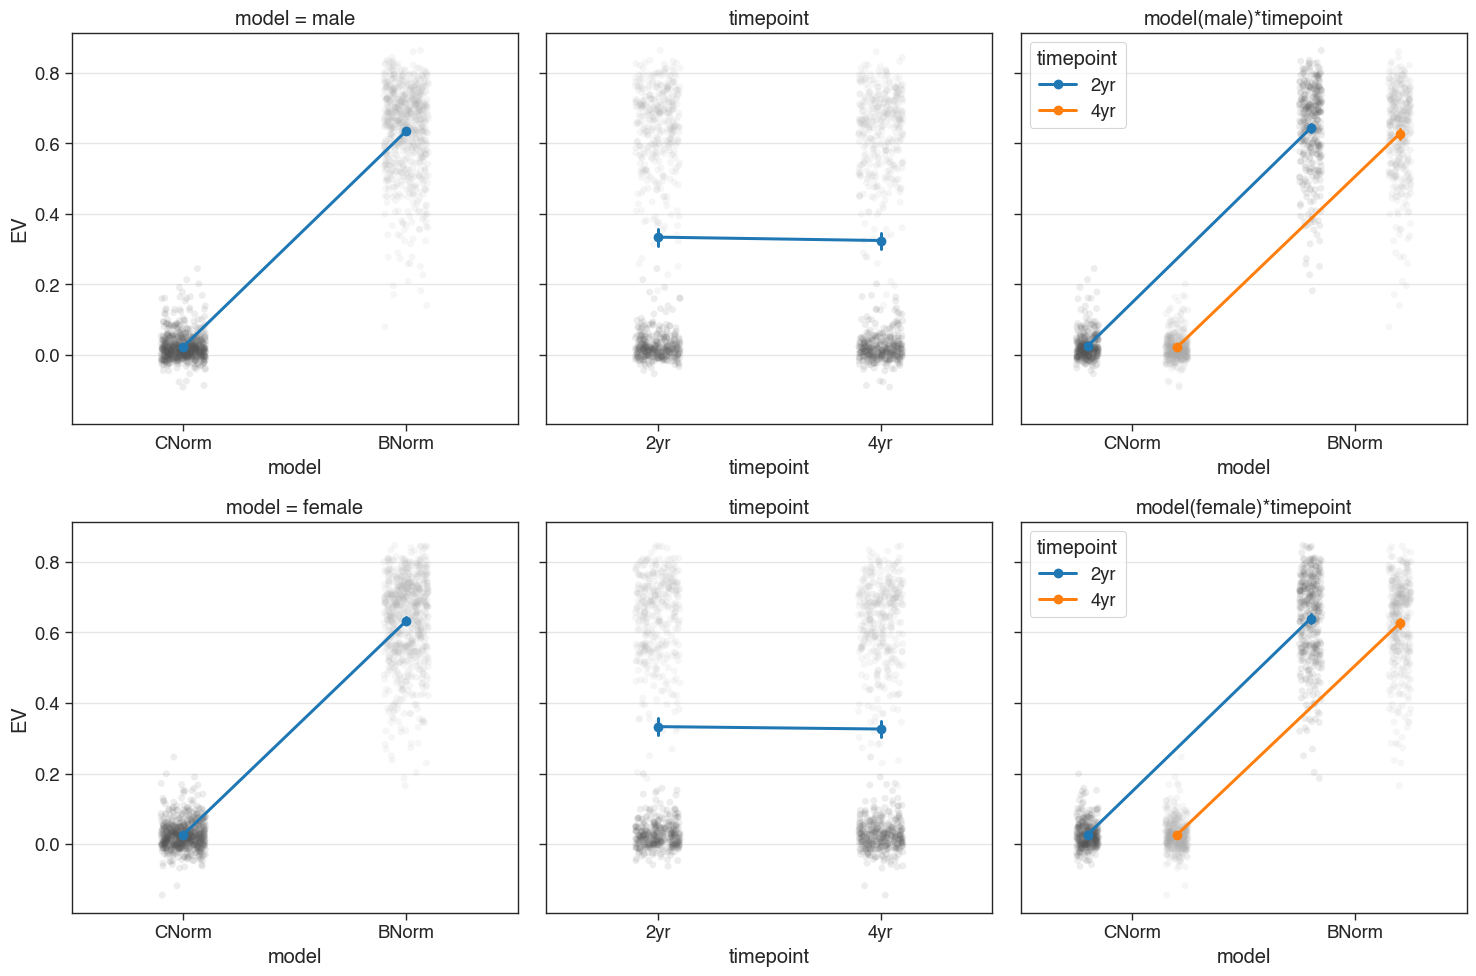

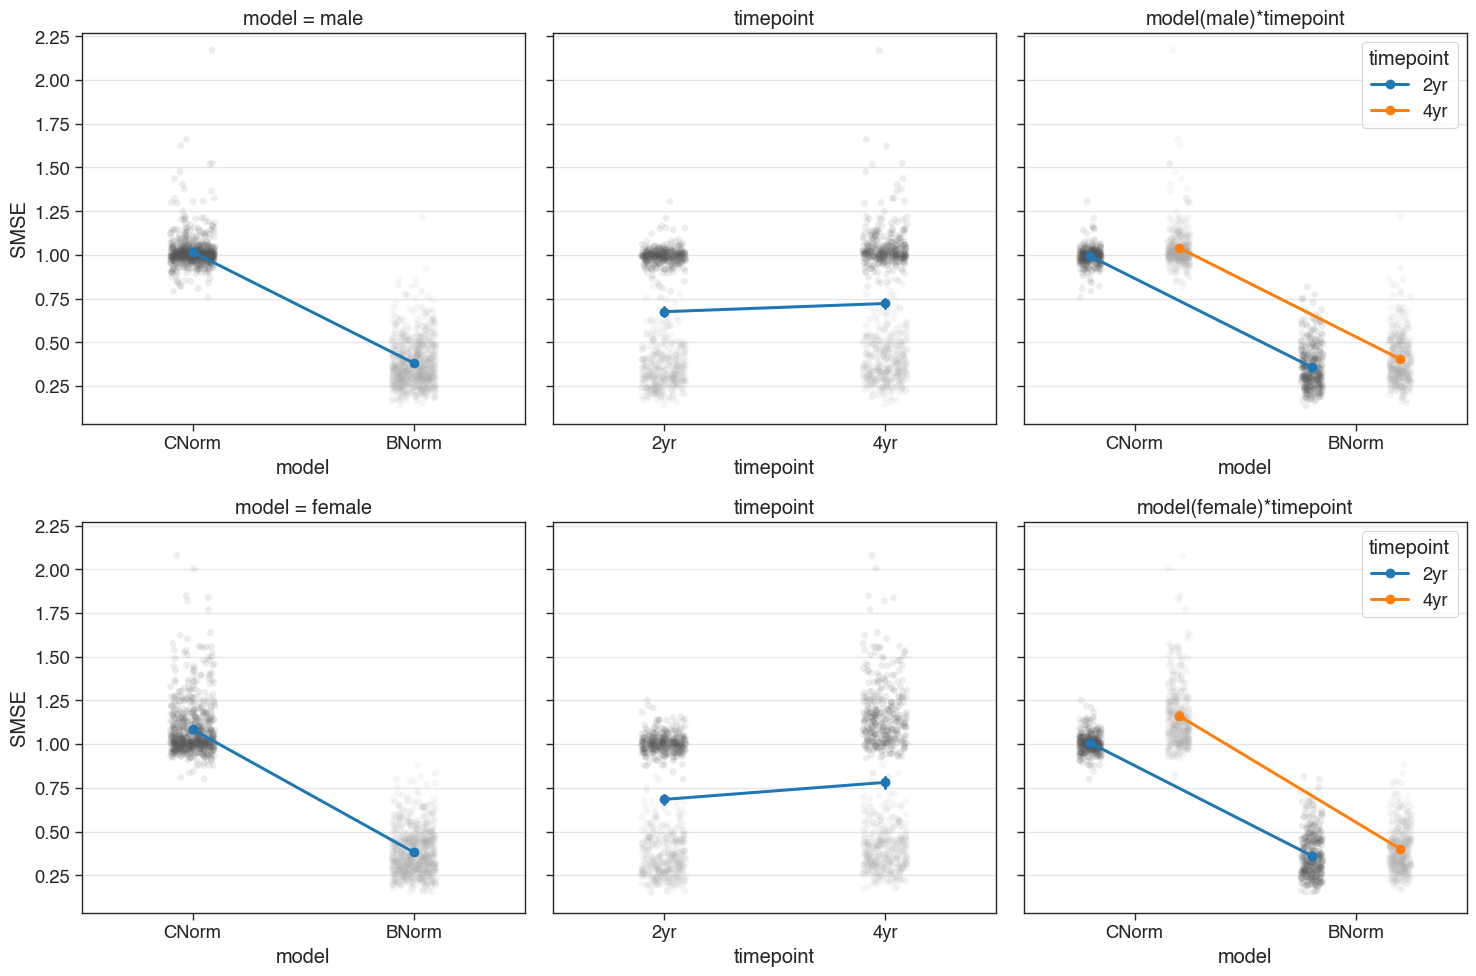

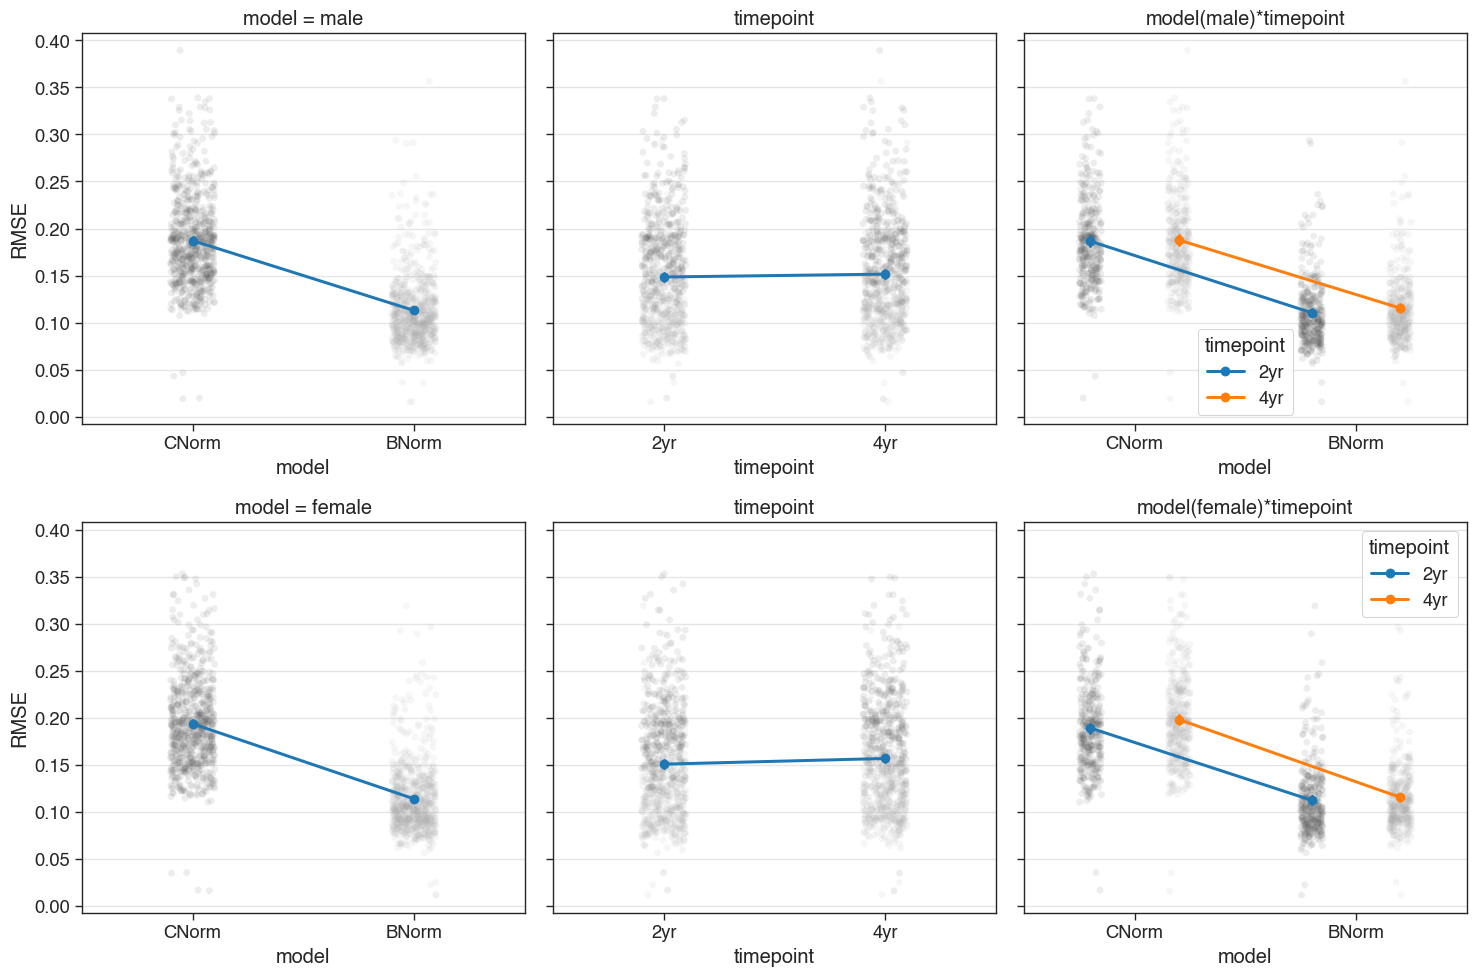

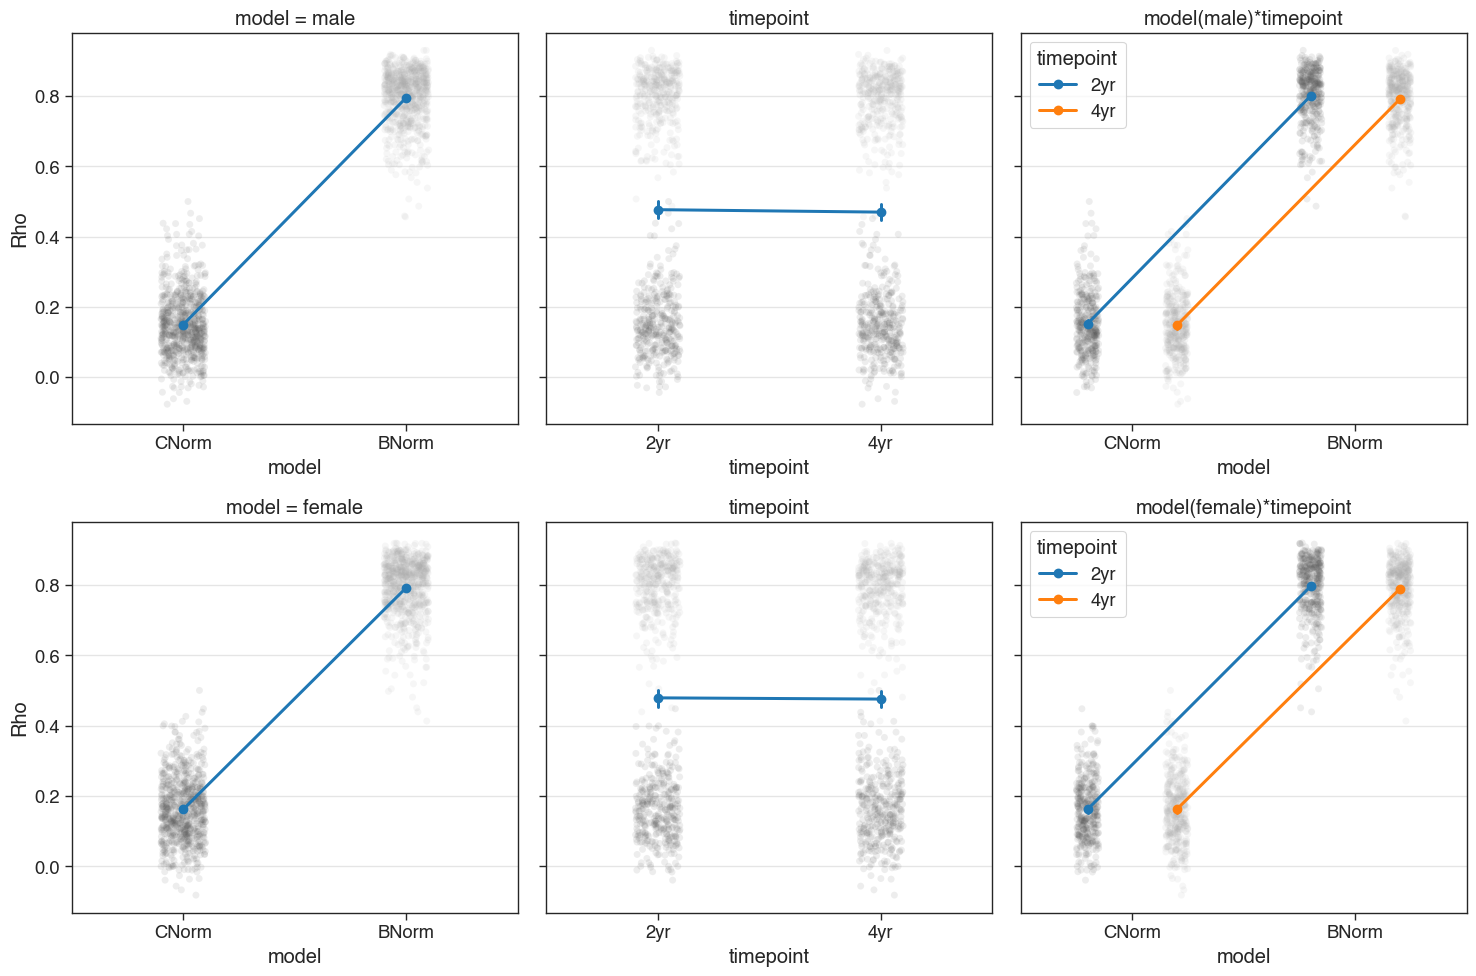

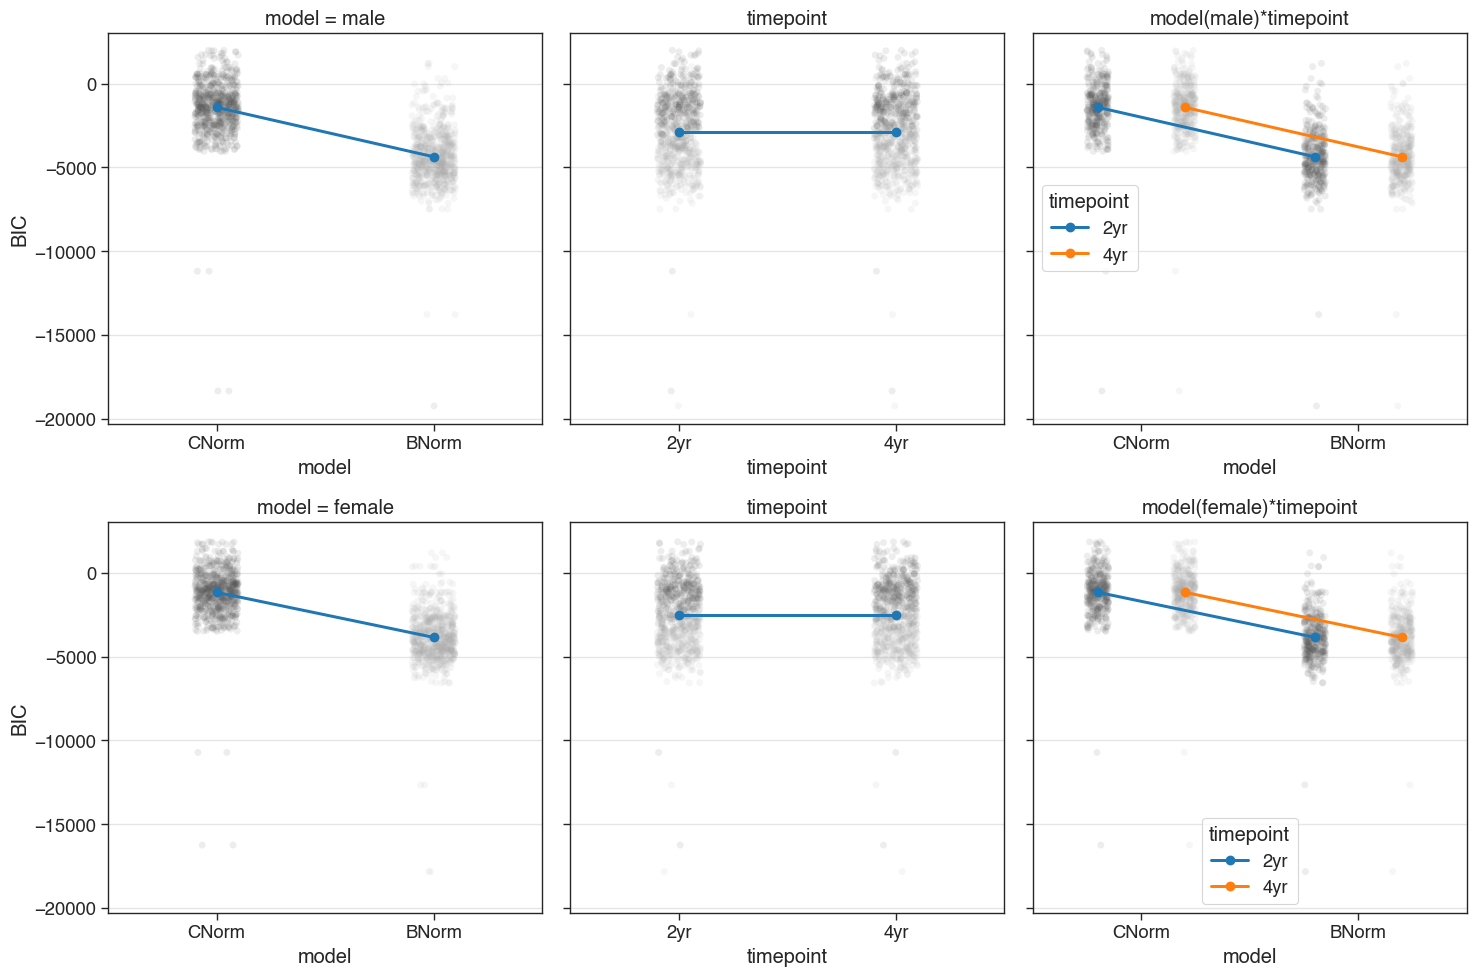

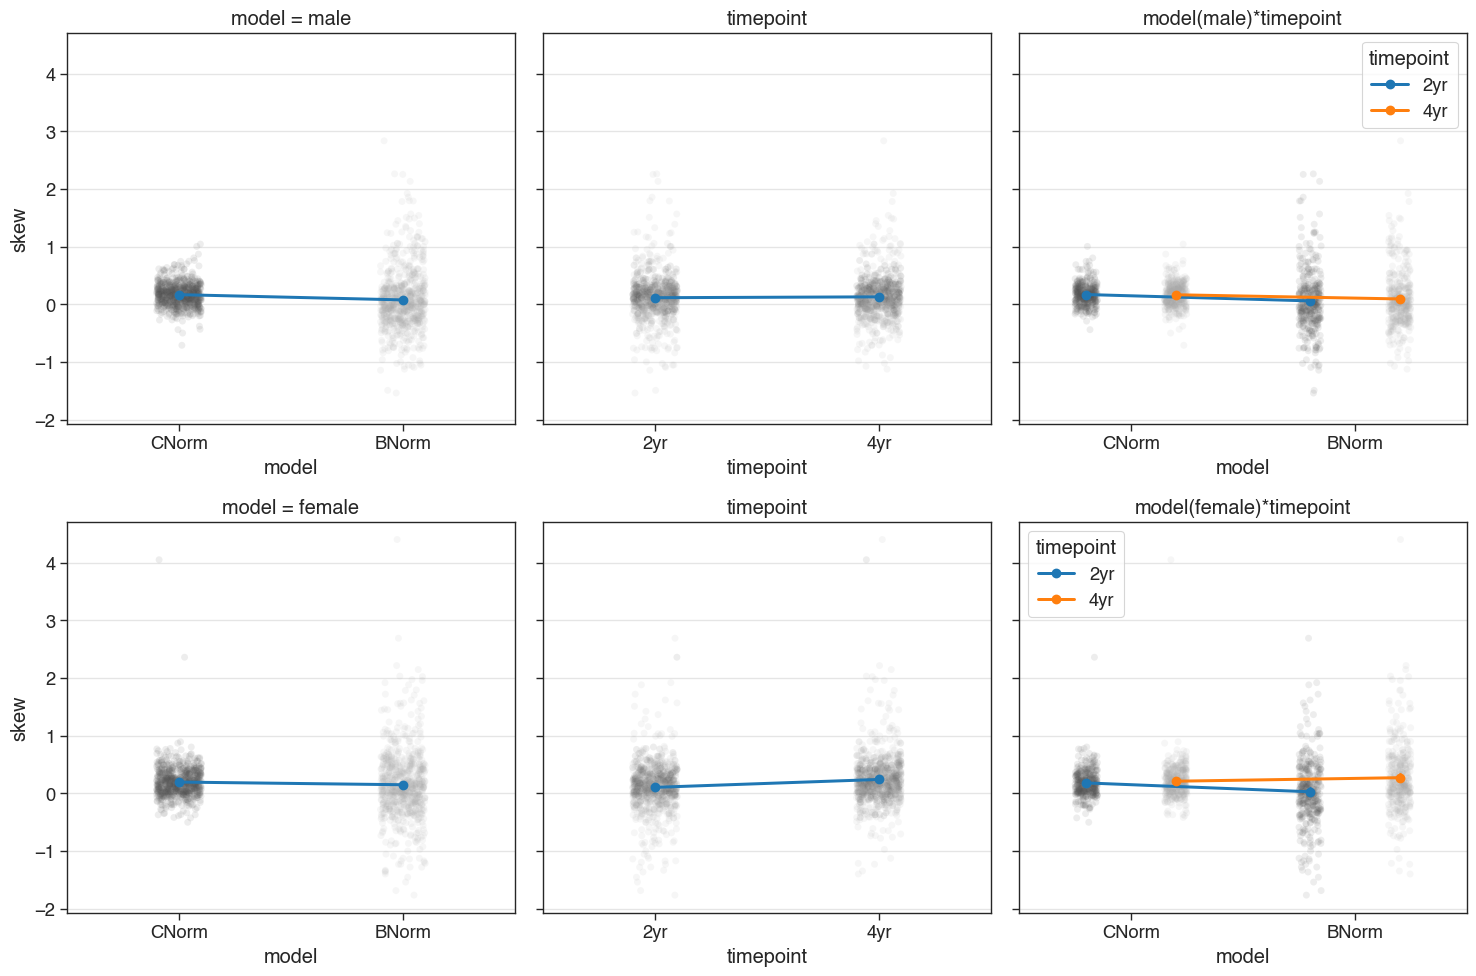

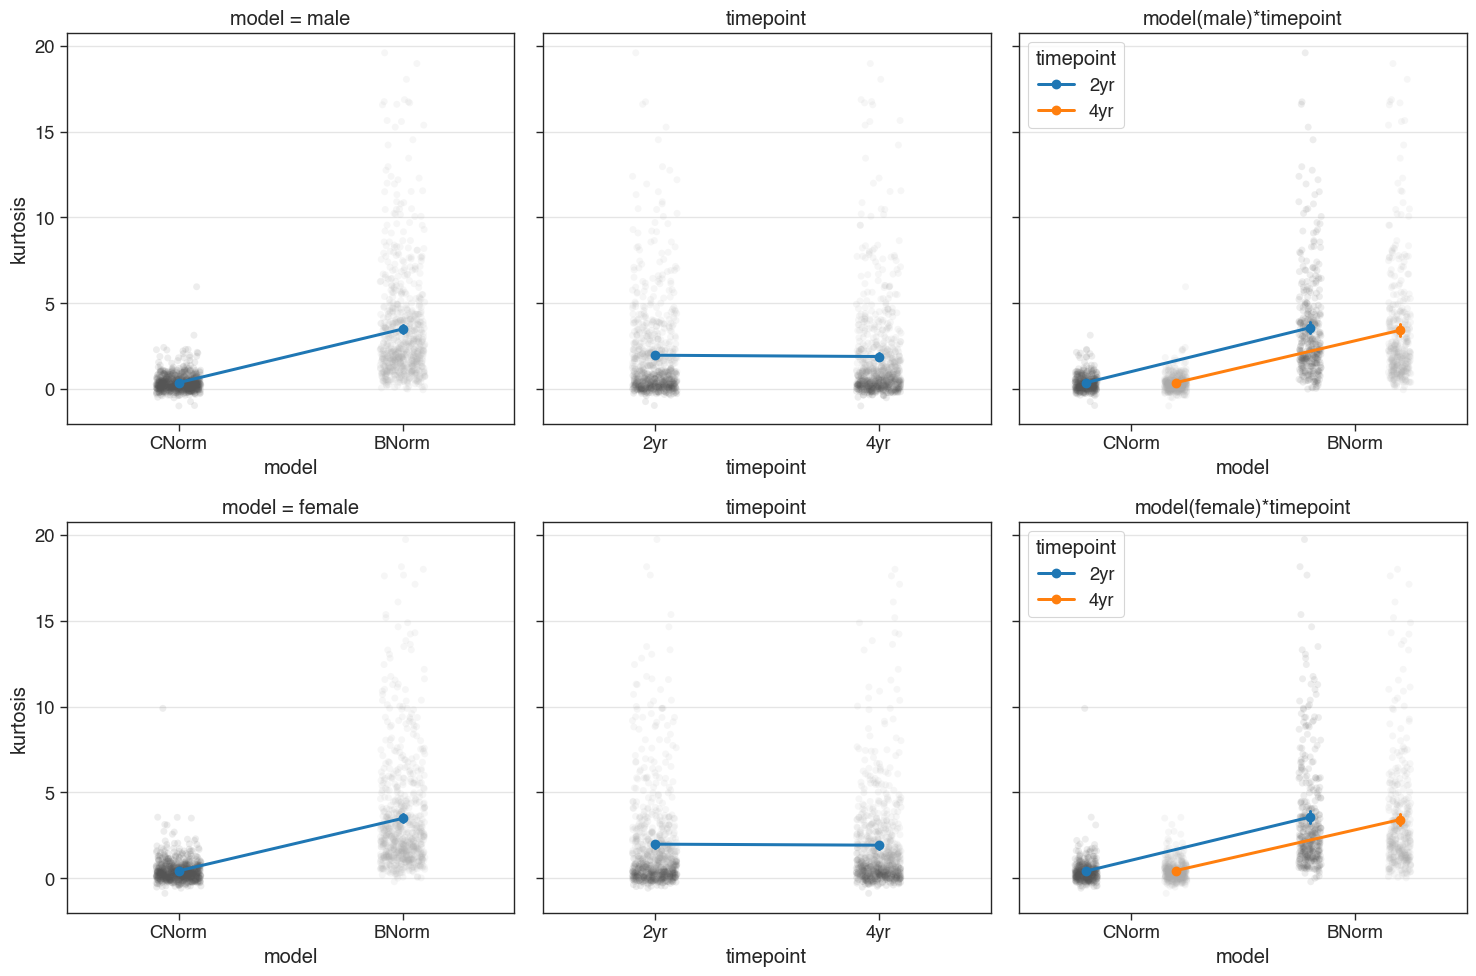

In [9]:
# plot interaction plots for the metrics
for m, metric in enumerate(combined.columns[1:9]):
    fig, axes = utils.make_anova_plots(data, metric, figsize=(15, 10))
    
    for ax in axes.flatten():
        ax.grid(visible=True, linewidth=1, alpha=.5, axis='y')
        if metric == 'MSLL':
            ax.set_ylim([-10, 150]) # some crazy outliers squish everything.
        
    fig.tight_layout()
    plt.savefig(os.path.join(supp_plot_dir,  f'sexspecific_{metric}_interaction_plots.pdf'), transparent=False, dpi=300)

# since Rho is bound between -1 and 1, we need to do an arctanh transformation before we do the statistics.
data.Rho = np.arctanh(performances_wo_avg.Rho) # need to do this before doing a statistical test

We provide more written information about the different metrics in the supplementary materials. 

The following code block is to have the summary statistics (e.g., mean and standard error values) for the male/female models and the timepoints. </br>This was important for the main text and the supplements. 

##### Summary Statistics

In [10]:
from scipy.stats import ttest_ind

# set the variable you want to run statistics on can be:
# Rho, EV, RMSE, SMSE, MSLL, skew, kurtosis, BIC
metric = 'EV' 
lbls = data.ROI.unique()

# we want to know which lobe a particular roi is part of.
# Kaufmann et al., defined lobes based on Glasser ROIs. We use this definition here.
lobe_data = load_lobe_data(lbls)
lobe_data.loc[lobe_data.lobe.isna(), "lobe"] = 'other'

# create a dataframe holding the output
df_stats = pd.DataFrame(columns=["model", "sex", "timepoint", "mean", "sem"])


for mID in MODEL_IDS:
    for sex in DS_IDS:
        for x in data.timepoint.unique():
            mu = data[(data.sex==sex) & (data.model==mID) & (data.timepoint==x)][metric].mean()
            sd = data[(data.sex==sex) & (data.model==mID) & (data.timepoint==x)][metric].std()
            sem = sd/np.sqrt(len(data[(data.sex==sex) & (data.model==mID) & (data.timepoint==x)][metric]))
            df_stats.loc[len(df_stats)] = [mID, sex, x, mu, sem]
            
df_stats

model     sex timepoint      mean       sem
0  CNorm    male       2yr  0.024850  0.002010
1  CNorm    male       4yr  0.021023  0.002010
2  CNorm  female       2yr  0.026646  0.001956
3  CNorm  female       4yr  0.025996  0.002306
4  BNorm    male       2yr  0.642806  0.006439
5  BNorm    male       4yr  0.627440  0.006757
6  BNorm  female       2yr  0.639412  0.006537
7  BNorm  female       4yr  0.626474  0.006523

We then checked which ROIs had the highest and lowest _metric_ scores. </br>
That was just done for the paper. 

##### 15 largest and lowest _metric_ values

In [11]:
# NOTE: CAN PROBABLY BE REMOVED
# Largest/smallest ROI values according to lobe
for sex in DS_IDS:
    for mID in MODEL_IDS:
        a = data[(data.sex==sex) & (data.model==mID) & (data.timepoint=="2yr")]
        a['lobe'] = lobe_data.lobe.values
        print(f'15-largest, {sex}, {mID}\n', a.nlargest(15, [metric])[['ROI', metric, 'lobe']])
        print(f'15-smallest, {sex}, {mID}\n', a.nsmallest(15, [metric])[['ROI', metric, 'lobe']])

15-largest, male, CNorm
              ROI        EV       lobe
51        lh_L_1  0.244841   parietal
232       rh_R_1  0.213266   parietal
1        lh_L_V1  0.191483  occipital
182      rh_R_V1  0.178108  occipital
92      lh_L_13l  0.161428    frontal
303    rh_R_PeEc  0.160431   temporal
85   lh_L_a9-46v  0.159193    frontal
54       lh_L_6d  0.138842    frontal
9        lh_L_3b  0.131234   parietal
86    lh_L_9-46d  0.128746    frontal
291     rh_R_Pir  0.122708      other
308    rh_R_PHA3  0.115851   temporal
347    rh_R_pOFC  0.104259    frontal
185      rh_R_V2  0.098088  occipital
329      rh_R_PF  0.095435   parietal
15-smallest, male, CNorm
            ROI        EV       lobe
93    lh_L_OFC -0.053522    frontal
43   lh_L_SCEF -0.044244    frontal
63    lh_L_8BM -0.036787    frontal
304  rh_R_STGa -0.033413   temporal
119  lh_L_PreS -0.030597   temporal
324   rh_R_PGp -0.027251   parietal
153  lh_L_VMV1 -0.026529  occipital
224  rh_R_SCEF -0.026148    frontal
41   lh_L_24dv -0

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/2138594006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['lobe'] = lobe_data.lobe.values
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/2138594006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['lobe'] = lobe_data.lobe.values
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/2138594006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

We also checked the ROI-wise differences in the _metric_ scores between timepoint 2yr and 4yr. These plots just appear in the supplementary material. </br>
Provided for completeness.

##### Pair-wise differences (2yr minus 4yr)

<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/920823945.py:27: SyntaxWarning: invalid escape sequence '\D'
  a.set_xlabel(f'$\Delta${metric} (2yr-4yr)')


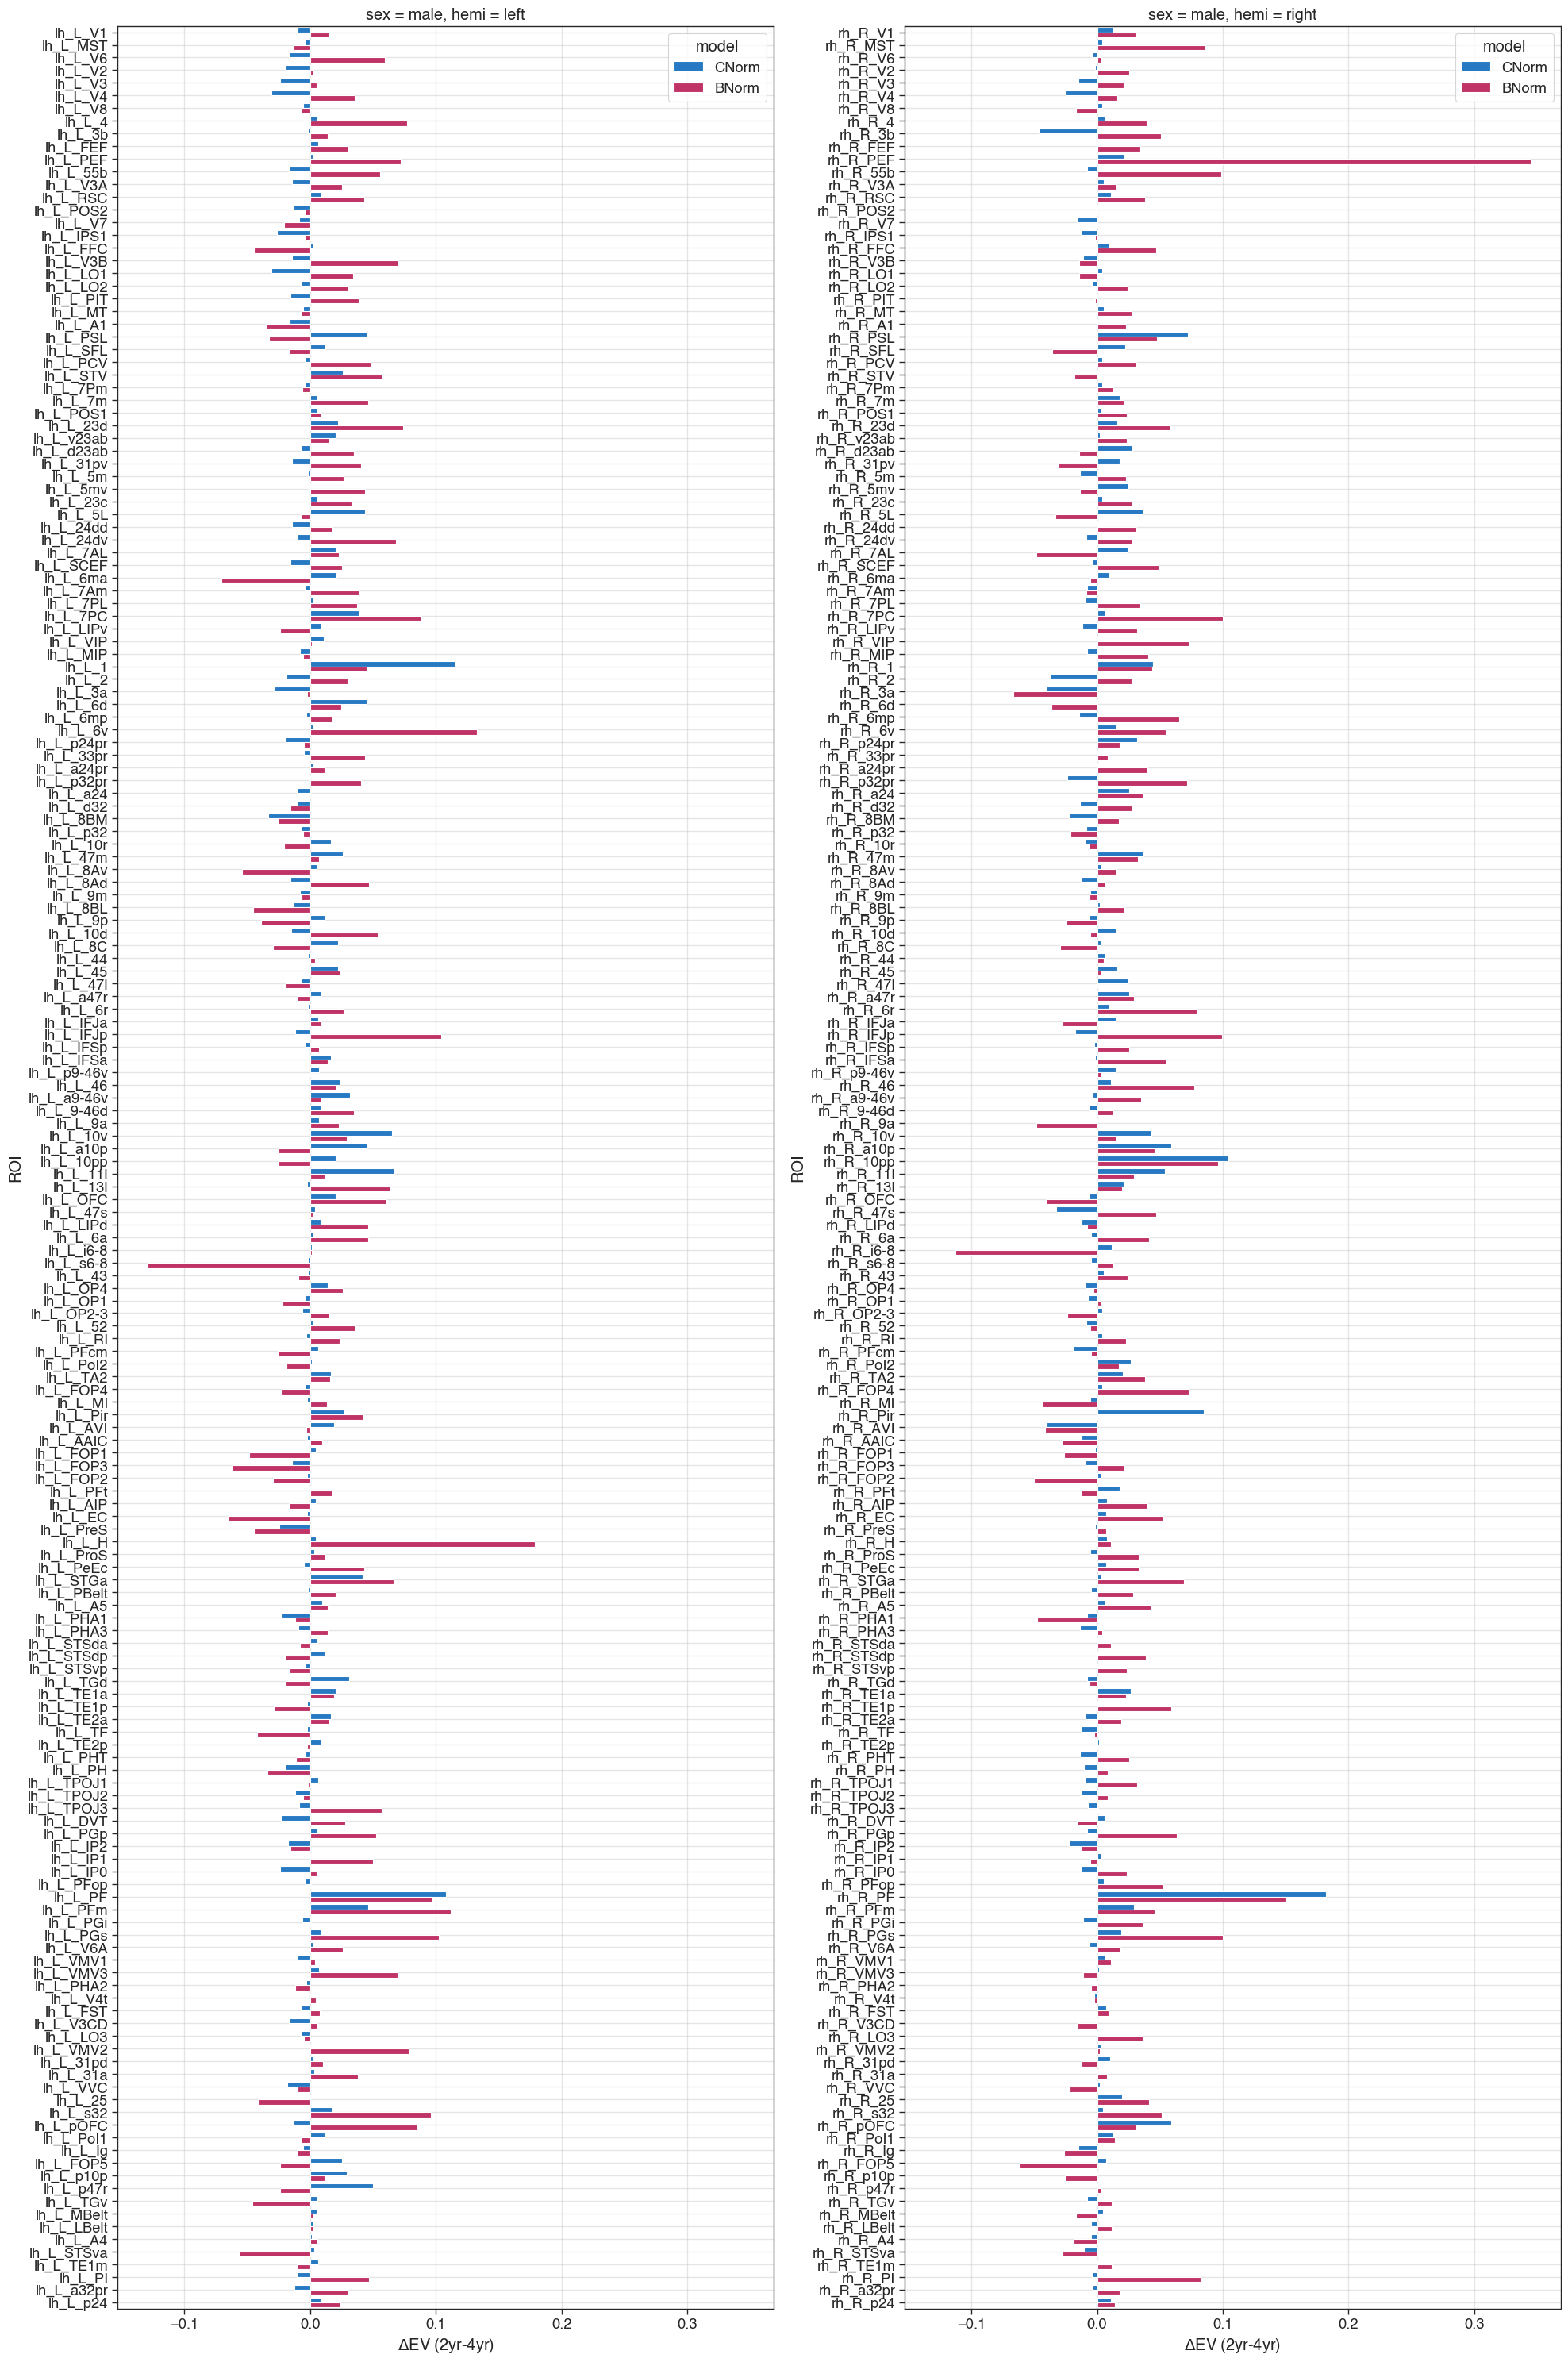

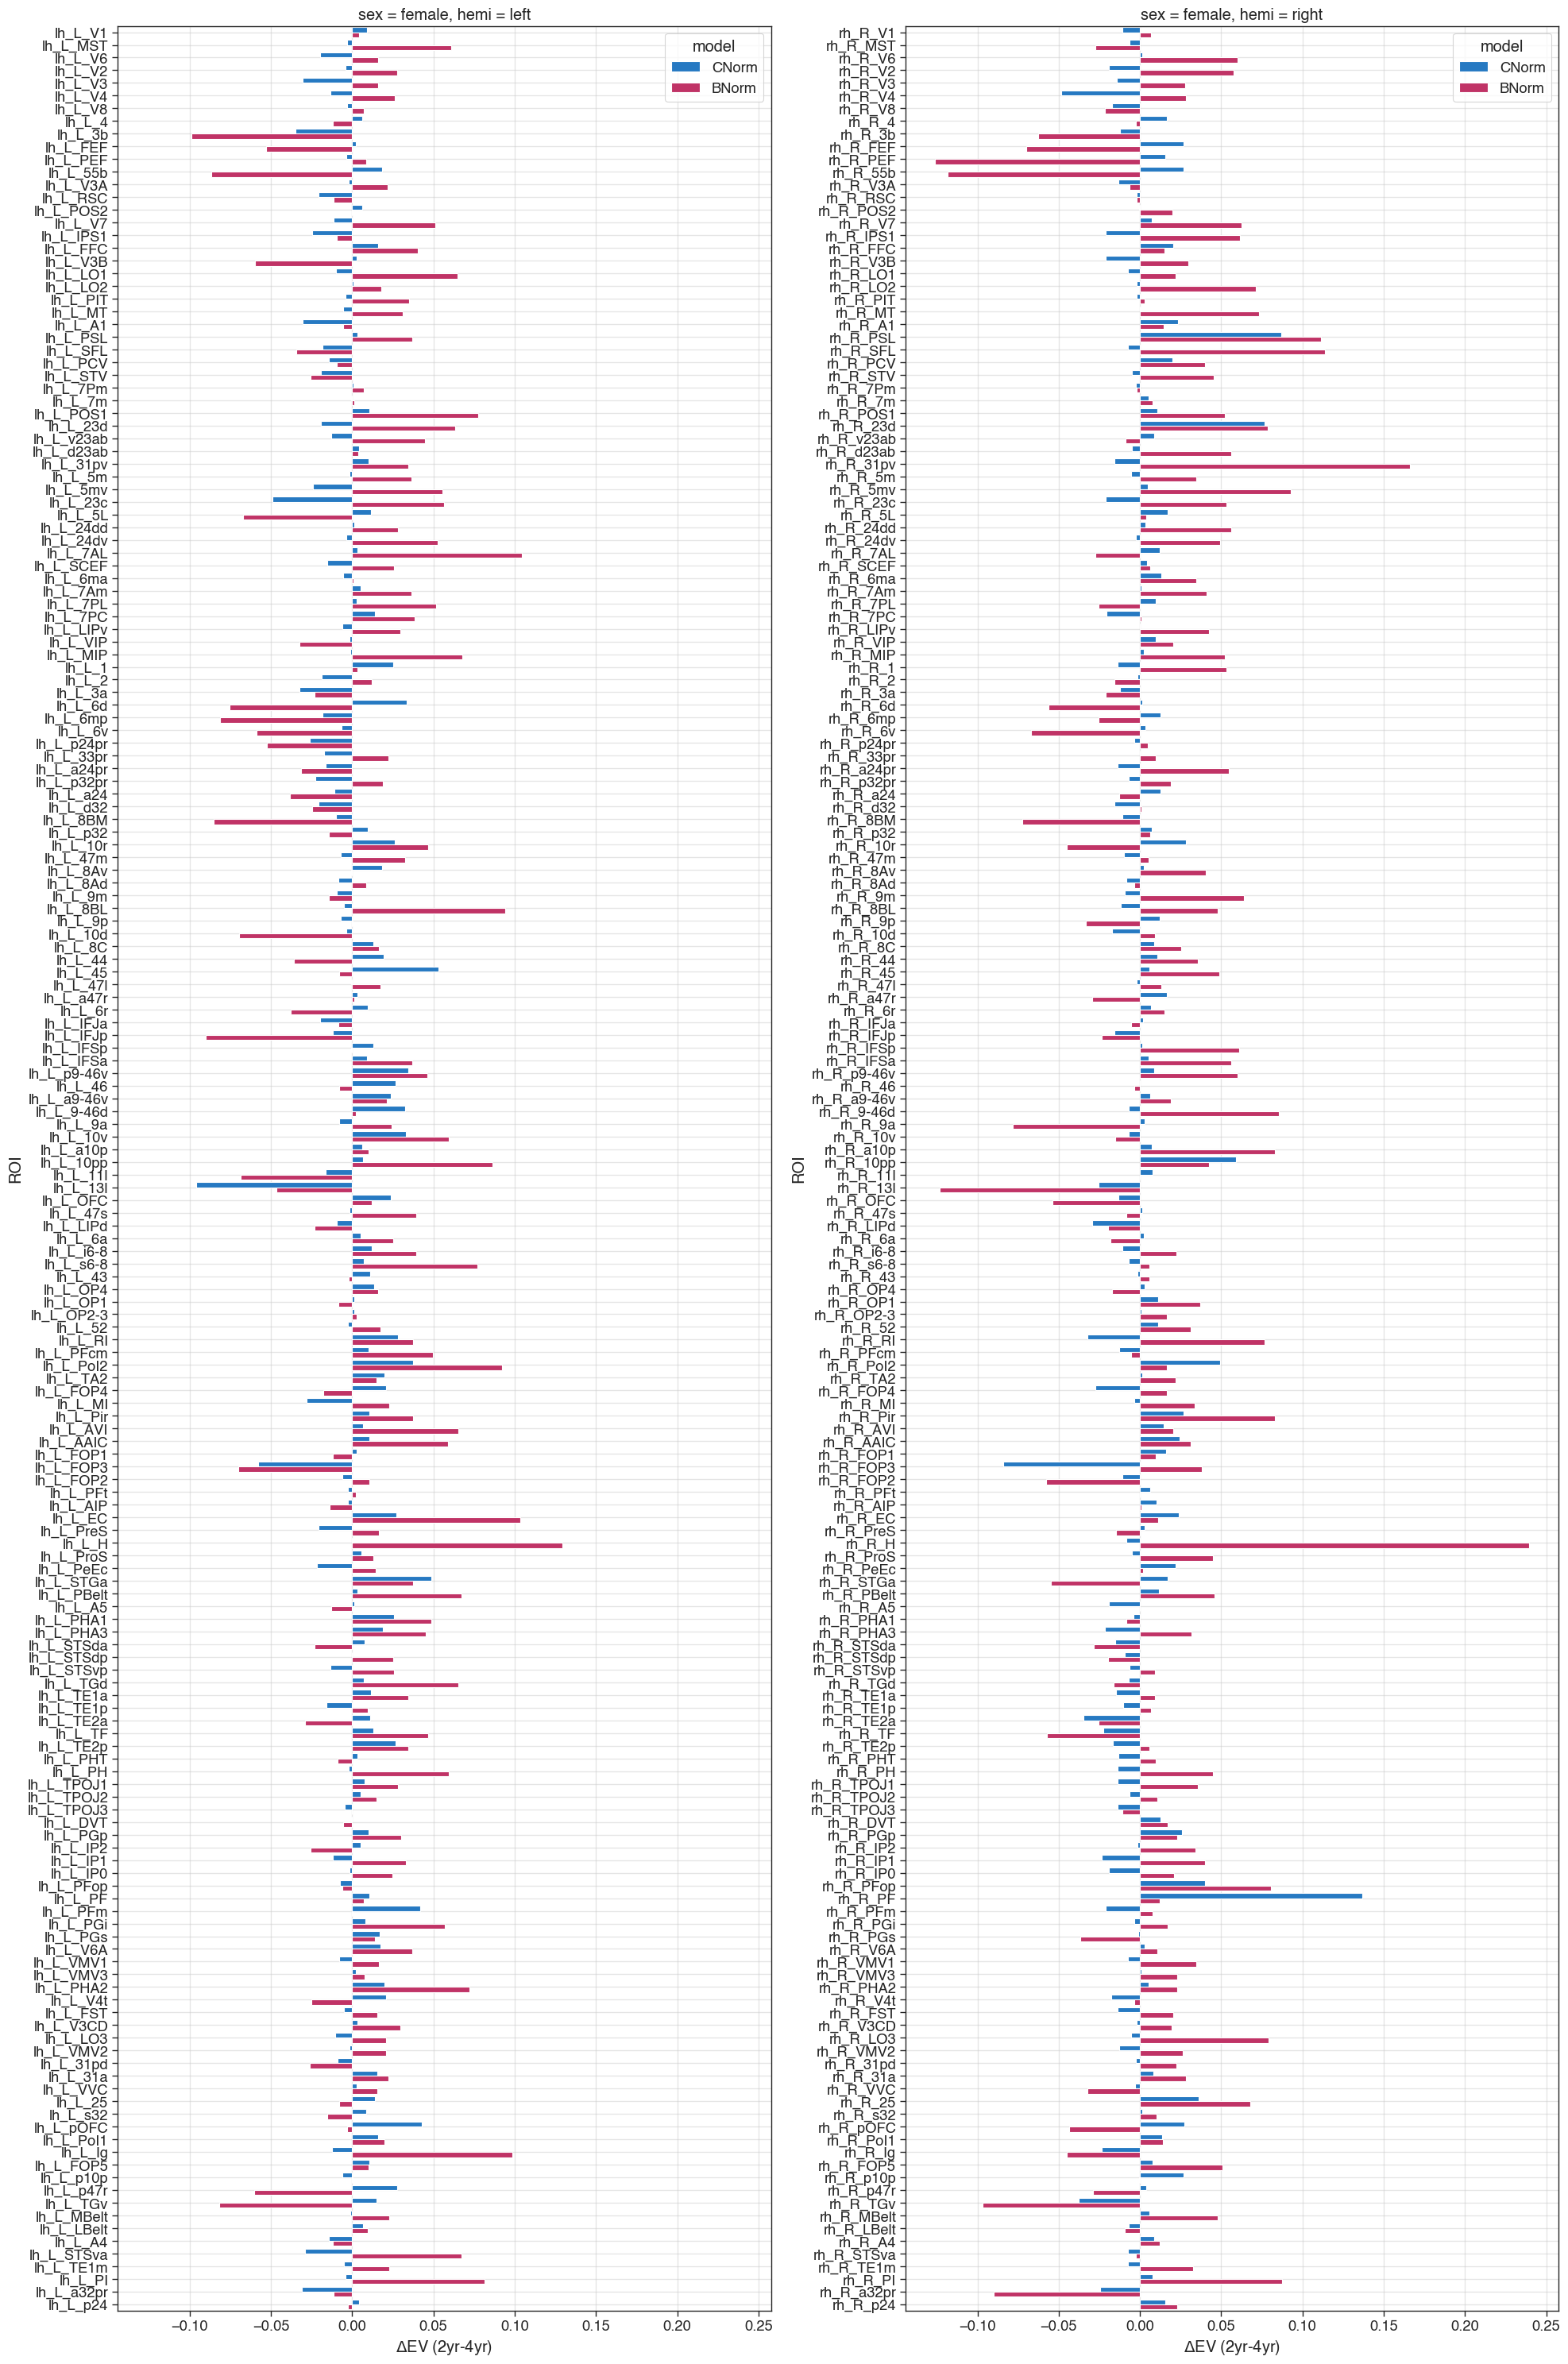

In [12]:
# plot roi-wise difference of stats between timepoints (within model)
lbls = data.ROI.unique()
lobe_data = load_lobe_data(lbls)

diff_metric = []
for sex in DS_IDS:
    for mID in MODEL_IDS:
        a = data[(data.sex==sex) & (data.model==mID) & (data.timepoint=="2yr")][['ROI', metric]]
        b = data[(data.sex==sex) & (data.model==mID) & (data.timepoint=="4yr")][['ROI', metric]]
        c = a[metric].values-b[metric].values
        diff_metric.append(pd.DataFrame({'ROI': lbls, '2yr-4yr': c, 'sex': sex, 'model': mID, 'lobe': lobe_data.lobe.tolist()}))

full = pd.concat(diff_metric, axis=0)

hemi = ['left', 'right']
for sex in DS_IDS:
    fig, ax = plt.subplots(1, 2, figsize=(20, 30), sharex=True)
    
    # .sort_values('lobe') could help in plotting
    sns.barplot(ax=ax[0], data=full[(full.sex==sex) & (full.ROI.isin(full.ROI[0:180]))], 
                x='2yr-4yr', y='ROI', hue='model', palette=colors)
    sns.barplot(ax=ax[1], data=full[(full.sex==sex) & (full.ROI.isin(full.ROI[180:360]))], 
                x='2yr-4yr', y='ROI', hue='model', palette=colors)
    
    for c, a in enumerate(ax):
        a.grid(visible=True, linewidth=1, alpha=.5, axis='both')
        a.set_xlabel(f'$\Delta${metric} (2yr-4yr)')
        a.set_title(f'sex = {sex}, hemi = {hemi[c]}')

    fig.tight_layout()
    plt.savefig(os.path.join(plot_out_dir, 'supplements', f'{metric}_{sex}.pdf'), transparent=False, dpi=300)

We then finally compute the 2-factor repeated measures anova for _metric_. </br>
We also provide the post-hoc pair-wise comparisons either in the main text of the paper or in the supplements. 

##### 2-factor repeated measures ANOVA for _metric_

In [13]:
for s, sex in enumerate(['male', 'female']):
    sex_data = data[data.sex == sex]
    print(sex)
    aov = rm_anova(data=sex_data, dv=metric, within=['model', 'timepoint'], detailed=True, subject='ROI', effsize='np2')
    print(aov)
    print('pairwise')
    print(pairwise_ttests(dv=metric, within=['model', 'timepoint'], subject='ROI', data=sex_data))

male
              Source          SS  ddof1  ddof2          MS            F  \
0              model  134.918144      1    359  134.918144  7855.030079   
1          timepoint    0.033154      1    359    0.033154    51.245127   
2  model * timepoint    0.011983      1    359    0.011983    25.864015   

           p-unc      p-GG-corr       np2  eps  
0  4.076987e-246  4.076987e-246  0.956294  1.0  
1   4.633272e-12   4.633272e-12  0.124913  1.0  
2   5.913520e-07   5.913520e-07  0.067203  1.0  
pairwise
            Contrast  model      A      B Paired Parametric          T    dof  \
0              model      -  BNorm  CNorm   True       True  88.628608  359.0   
1          timepoint      -    2yr    4yr   True       True   7.158570  359.0   
2  model * timepoint  BNorm    2yr    4yr   True       True   7.015936  359.0   
3  model * timepoint  CNorm    2yr    4yr   True       True   3.267979  359.0   

  alternative          p-unc        BF10    hedges  
0   two-sided  4.076987e-246  

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupb

IMPORTANT NOTE: Skewness and Kurtosis are quite sensitive to outliers. We wanted to see if the statistics change dramatically if we remove outliers within a ROI. </br>
This is shown below. The results will be available in the supplementary materials.


In [14]:
# load all z-scores first
all_z = []
for sex in DS_IDS:
    for model in MODEL_IDS:
        inter = pd.read_csv(os.path.join(stats_out_dir, model, sex, 'all_z.csv'))
        inter['sex'] = sex
        all_z.append(inter)

all_z = pd.concat(all_z, axis=0)

# skew and kurtosis adjusted for extreme outliers (mean+6*SD)
outlier_adjusted = data.copy()

new_skew, new_kurtosis = [],[]
for mID in MODEL_IDS:
    for sex in DS_IDS:
        for tpt in TIMEPOINTS:
            for roi in outlier_adjusted.ROI.unique():
                this = all_z[(all_z.model == mID) & (all_z.timepoint == tpt) & (all_z.sex==sex)][roi]
                this = this[np.abs(this)<(this.mean() + this.std()*6)]

                this_skew, _, this_kurtosis, _, _, _ = utils.calibration_descriptives(this.values) # pandas gives different kurtosis values
                new_skew.append(this_skew)
                new_kurtosis.append(this_kurtosis)

outlier_adjusted.loc[:, "kurtosis"] = new_kurtosis
outlier_adjusted.loc[:, "skew"] = new_skew

In [15]:
# compute the statistics based on the adjusted data. Put this into the supplements
metric = 'kurtosis'

for s, sex in enumerate(['male', 'female']):
    sex_data = outlier_adjusted[outlier_adjusted.sex == sex]
    print(sex)
    aov = rm_anova(data=sex_data, dv=metric, within=['model', 'timepoint'], detailed=True, subject='ROI', effsize='np2')
    print(aov)
    print('pairwise')
    print(pairwise_ttests(dv=metric, within=['model', 'timepoint'], subject='ROI', data=sex_data))

male
              Source        SS  ddof1  ddof2        MS         F     p-unc  \
0              model  0.820910      1    359  0.820910  2.481059  0.116105   
1          timepoint  0.040009      1    359  0.040009  0.390974  0.532185   
2  model * timepoint  0.344515      1    359  0.344515  2.913531  0.088704   

   p-GG-corr       np2  eps  
0   0.116105  0.006864  1.0  
1   0.532185  0.001088  1.0  
2   0.088704  0.008050  1.0  
pairwise
            Contrast  model      A      B Paired Parametric         T    dof  \
0              model      -  BNorm  CNorm   True       True  1.575138  359.0   
1          timepoint      -    2yr    4yr   True       True -0.625279  359.0   
2  model * timepoint  BNorm    2yr    4yr   True       True -1.452986  359.0   
3  model * timepoint  CNorm    2yr    4yr   True       True  1.006477  359.0   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.116105  0.202  0.102230  
1   two-sided  0.532185  0.072 -0.026279  
2   two-sided  0.147101

/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Users/philis/anaconda3/envs/norm312/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupb

# FIGURE/STATS #2 - ASSOCIATION WITH PDS SCORES

We investigate whether deviation scores were associated with puberty ratings as rated by the youths’ caregivers. To do so, we extracted all z-scores of the 2-year or 4-year follow-up test data. We then again used pythons statsmodels glm function using the formula PDS(t) ~ zROI(t) where PDS corresponds to the subject-wise mean pubertal score as rated by the caregivers and zROI to the subject-wise deviation scores at timepoint t (i.e., 2-year or 4-year). This resulted in 360 t-scores and p-values (which we corrected for multiple comparisons using the Benjamini-Hochberg false discovery method), one for each ROI, for each model, and sex.  

In [16]:
# we first get all z-scores from the male/female C-Norm and B-Norm models for each ROI
all_z = []
for sex in DS_IDS:
    for mID in MODEL_IDS:
        df = pd.read_csv(os.path.join(stats_out_dir, mID, sex, 'all_z.csv'))
        df['sex'] = sex
        all_z.append(df)

all_z = pd.concat(all_z, axis=0)

# NOTE: we also trained a PDS normative model, but we're probably not gonna use that.
all_z_pds = []
for sex in DS_IDS:
    df = pd.read_csv((f"stats/all_z_{sex}_PDSmodels.csv"))
    all_z_pds.append(df)

all_z_pds = pd.concat(all_z_pds, axis=0)

## Associate z-scores of brain models with raw PDS scores

In [17]:
def associate_pds_with_z(demodata, yname, rois, sex, model_id, timepoint, test_string, atlas='glasser') -> pd.DataFrame:
    """
    Associates PDS scores with z-scores as obtained from C- or B-Norm models.
    
    Parameters
    ----------
    demodata : pandas.DataFrame
        contains the demographic data, e.g., die PDS scores as rated by caregivers.
    yname : str
        name of the column used for demodata
    rois : list
        list of Glasser ROIs for which to perform the association test.
    sex : str
    model_id : str
    timepoint : str
    test_string : str
        Tells the glm function what test to perform.
    atlas(optional) : str, Default: glasser
    
    Returns
    -------
    stats : pd.DataFrame
        contains computed stats
    """

    stats = pd.DataFrame(columns=["ROI", "rho", "tstat", "pval", "pfdr", "sex", "model", "timepoint"])

    for r, roi in enumerate(rois):
        # load the z-scores for the current ROI for a given model
        f_name = os.path.join("model_output", atlas, model_id, sex, roi, f"evaluate_{timepoint}/Z_predict.txt")
        deviation_scores = np.loadtxt(f_name)

        demodata['z'] = deviation_scores
        demodata = demodata.dropna().reset_index(drop=True)

        # TODO: YOU PROBABLY NEED TO IMPLEMENT AN IF STATEMENT FOR THE FULL MODEL

        rho = np.corrcoef(demodata.z.values, demodata[yname].values)[0, 1]
        model = glm(test_string, data=demodata).fit()
        stats.loc[r] = [roi, rho, model.tvalues.values[1:][0], model.pvalues.values[1:][0], 0, sex, mID, timepoint]

    stats["pfdr"] = multipletests(stats["pval"], method="fdr_bh")[1]

    return stats

In [18]:
ethnicities = ['White', 'Black', 'Hispanic', 'Asian', 'Other']
pds_from = "p"

# load the data
for m, mID in enumerate(MODEL_IDS):  # loop over models
    for d, sex in enumerate(DS_IDS):  # loop over data splits
        rho, tvals, pvals, pcorr = [], [], [], []

        for t, tpt in enumerate(TIMEPOINTS):  # loop over timepoints
            print(mID, sex, tpt)
            # load the data
            this_data = pd.read_csv(os.path.join("data", f"test_{sex}_f2.csv"))

            # PDS ~ z
            model_string_PDS = f'PDS_mean_{pds_from}_{tpt} ~ z'

            stats = associate_pds_with_z(this_data, f"PDS_mean_{pds_from}_{tpt}", ROI_lbls,
                                        sex, mID, tpt, model_string_PDS)

            out_name = os.path.join(stats_out_dir, mID, sex, f"asso_pds-z_{tpt}.csv")
            stats.to_csv(out_name, index=False)

CNorm male 2yr
CNorm male 4yr
CNorm female 2yr
CNorm female 4yr
BNorm male 2yr
BNorm male 4yr
BNorm female 2yr
BNorm female 4yr


/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/324503128.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels([x if len(x)==3 else x[1:] for x in y_labels])
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/324503128.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels([x if len(x)==3 else x[1:] for x in y_labels])


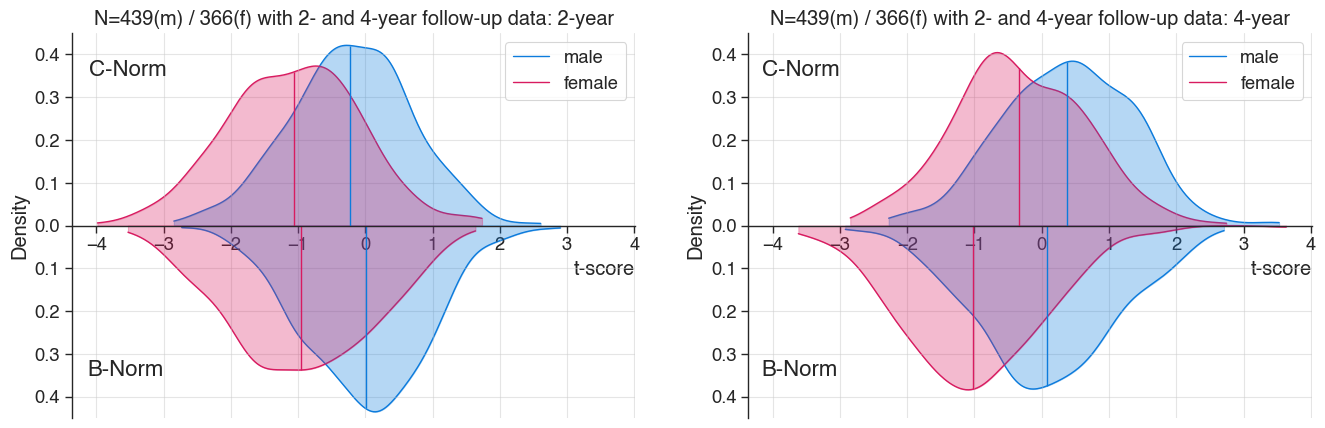

In [19]:
from scipy.stats import gaussian_kde

stat = 'tstat'
title_labels = ["N=439(m) / 366(f) with 2- and 4-year follow-up data: 2-year", 
                "N=439(m) / 366(f) with 2- and 4-year follow-up data: 4-year"]

fig, axes = plt.subplots(1,2, figsize=(16, 5), sharex=True)
for i, tpt in enumerate(TIMEPOINTS):
    axes[i].set_ylim([-.45, .45])
    #axes.set_xlim([-5.4, 3.5])

    for m, mID in enumerate(MODEL_IDS):
        
        flip = -1 if mID == 'BNorm' else 1
        model_label = 'BNorm' if mID == 'BNorm' else 'CNorm'

        for s, sex in enumerate(DS_IDS):

            data = pd.read_csv(os.path.join(stats_out_dir, mID, sex, f'asso_pds-z_{tpt}.csv'), 
                               usecols=['ROI', 'tstat', 'sex', 'model', 'timepoint'])
            
            ## plot density chart for sex-specific data
            kde = gaussian_kde(data.tstat, bw_method='scott')
            x_range = np.linspace(np.min(data.tstat), np.max(data.tstat), len(data.tstat))
            l = sns.lineplot(ax=axes[i], x=x_range, y=kde(x_range) * flip, color=colors[s], label=f'{sex}' if m == 0 else None, linewidth=1, zorder=0)
            axes[i].fill_between(x_range, kde(x_range) * flip, color=colors[s], alpha=.3)

            ## add the mean dots for the sex-specific models
            xs, ys = l.lines[-1].get_xdata(), l.lines[-1].get_ydata()
            height = np.interp(data.tstat.mean(), xs, ys)
            axes[i].vlines(x=data.tstat.mean(), ymin=0, ymax=height, color=colors[s], linewidth=1)
            
        # adding text inside the plot
        axes[i].text(axes[i].get_xlim()[0]+.2, (axes[i].get_ylim()[1]-.1)*flip, mID.replace('Norm', '-Norm'), fontsize = 16)

    y_labels = [item.get_text() for item in axes[i].get_yticklabels()]
    axes[i].set_yticklabels([x if len(x)==3 else x[1:] for x in y_labels])
    axes[i].set_title(title_labels[i])
    axes[i].spines['bottom'].set_position(('data', 0.0))
    axes[i].set_xlabel('t-score', horizontalalignment='right', x=1, y=-1)
    axes[i].legend(loc='upper right')# [0.005, .6]
    axes[i].grid(linestyle="-", alpha=0.5, zorder=1)

    utils.remove_axes(axes)
    axes[i].set_ylabel('Density')
plt.savefig(f"plots/glasser/pds_association/pds-vs-brain.pdf", transparent=False, dpi=300)

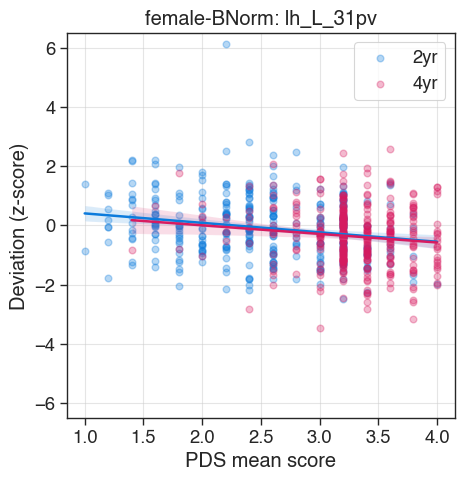

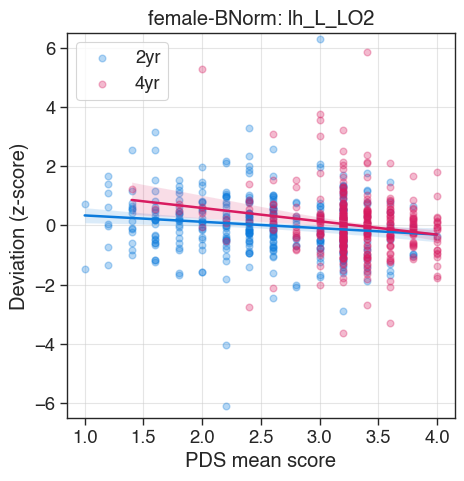

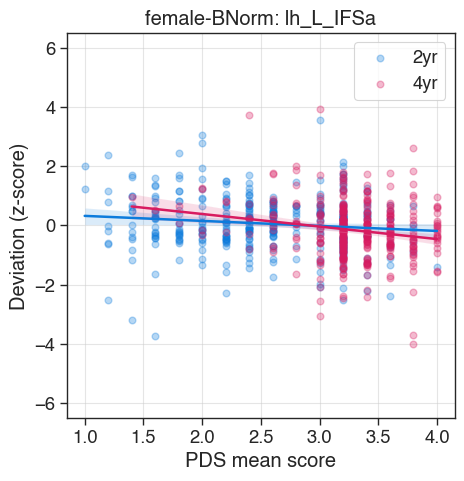

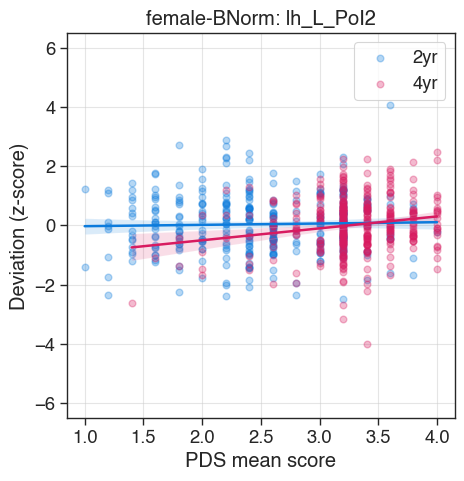

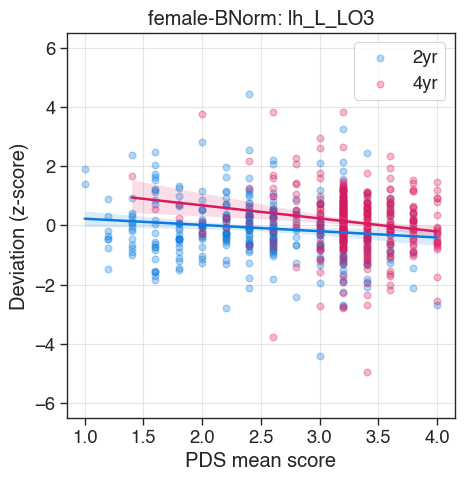

In [20]:
# plot the regression plot of the z-scores (x) and the PDS mean scores (y)
# load the demographic data
df_demo_male = pd.read_csv("data/test_male_f2.csv", usecols=["src_subject_id", "sex_bl", "PDS_mean_p_bl", "PDS_mean_p_2yr", "PDS_mean_p_4yr"])
df_demo_female = pd.read_csv("data/test_female_f2.csv", usecols=["src_subject_id", "sex_bl", "PDS_mean_p_bl", "PDS_mean_p_2yr", "PDS_mean_p_4yr"])
sexes = ['male', 'female']
timepoints = ["2yr", "4yr"]

data = []
for m, mID in enumerate(MODEL_IDS):    
    for t, tpt in enumerate(TIMEPOINTS):
        for s, sex in enumerate(DS_IDS):
            # check which area was significant
            data.append(pd.read_csv(os.path.join(stats_out_dir, f"{mID}/{sex}/asso_pds-z_{tpt}.csv")))

data = pd.concat(data, axis=0)
data_sig = data[data.pfdr<0.05].reset_index(drop=True)

for r, roi in enumerate(data_sig.ROI.unique()):
    fig, ax = plt.subplots(figsize=(5,5))    
    ax.set_ylim([-6.5, 6.5]) # CURRENTLY HARDCODED
    
    for t, tpt in enumerate(TIMEPOINTS):
        this_z = all_z[(all_z.model==data_sig.model[r]) & (all_z.sex==data_sig.sex[r]) & (all_z.timepoint==tpt)][roi].reset_index()
        to_plot = pd.concat([df_demo_male if s==0 else df_demo_female, this_z], axis=1)
        sns.regplot(ax=ax, data=to_plot, y=roi, x=f"PDS_mean_p_{tpt}", scatter_kws={'alpha': .3}, color=colors[t], label=tpt)
        ax.set_title(f"{sex}-{mID}: {roi}")
        ax.set_xlabel('PDS mean score')
        ax.set_ylabel('Deviation (z-score)')
        ax.grid(linestyle="-",alpha=0.5,zorder=1)
        
    plt.legend()
    plt.savefig(os.path.join(plot_out_dir, data_sig.model[r], data_sig.sex[r], f"scatter_asso_PDS-z_{roi}.pdf"), transparent=False, dpi=300)


# FIGURE/STATS #3 - FURTHER COMPARISON BETWEEN MODELS

## Load data

In [21]:
from scipy.stats import distributions
from scipy.stats import ttest_ind
from statsmodels.graphics.gofplots import qqplot, qqplot_2samples
from itertools import combinations 

all_z = []
for sex in ['male', 'female']:
    for model in MODEL_IDS:
        inter = pd.read_csv(os.path.join(stats_out_dir, model, sex, 'all_z.csv'))
        inter['sex'] = sex
        all_z.append(inter)

all_z = pd.concat(all_z, axis=0)

## Percent deviators

We are combining the ROIs into lobes. For each lobe, we then count the number of deviating regions within each lobe for each participant. </br>
We also assign the PDS category to each participant and perform a Kruskal-Wallis test to see if there are any differences between pds categories within each lobe. 

In [22]:
import scikit_posthocs as sp
data = performances_wo_avg[(performances_wo_avg.sex == 'female') | (performances_wo_avg.sex == 'male')]
lbls = data.ROI.unique()
lobe_data = load_lobe_data(lbls)
lobe_data.loc[lobe_data.lobe.isna(), "lobe"] = 'other'

In [23]:
thresh = 1.96
count_dict = {}
dfs = []

PDS_cats = ['prepubertal', 'early pubertal', 'midpubertal', 'late pubertal', 'postpubertal']

# dataframe holding information for the kruskal-wallis tests
group_test = pd.DataFrame(columns=["sex", "model", "timepoint", "lobe", "hemisphere", 
                                   "deviator", "median", "stat", "pval", "kGroups", "nSamples"])

# dataframe holding information for the pair-wise posthoc Dunn tests
posthoc_dunn = pd.DataFrame(columns=["sex", "model", "timepoint", "lobe", "hemisphere", 
                                     "deviator", "cat1", "cat2", "median", "pval"])
ctr = 0
ctrPost = 0
for sex in all_z.sex.unique():
    df_pub_cats = get_puberty_categories(sex)  # we will add these to the resulting dataframe

    for m in all_z.model.unique():
        for tpt in all_z.timepoint.unique():
            for lobe in lobe_data.lobe.unique():
                for hemi in ["lh", "rh"]:
                    lobe_rois = lobe_data[(lobe_data.lobe == lobe) & (lobe_data.ROI.str.contains(hemi))].ROI.values
                    these_rois = all_z[(all_z.model == m) & (all_z.sex == sex) & (all_z.timepoint == tpt)][
                        lobe_rois].reset_index(drop=True)

                    poslist, neglist = [], []

                    for i in range(len(these_rois)):
                        poslist.append(np.sum(these_rois.loc[i] > thresh).tolist())
                        neglist.append(np.sum(these_rois.loc[i] < -thresh).tolist())

                    count_dict[f'{hemi}_{lobe}_positive'] = poslist
                    count_dict[f'{hemi}_{lobe}_negative'] = neglist
                    
                    for dev in ["positive", "negative"]:
                        # Kruskal-Wallis test for deviator counts
                        vals, res, non_empty_idx = utils.run_kruskal_wallis(count_dict[f'{hemi}_{lobe}_{dev}'], df_pub_cats, tpt)
                        group_test.loc[ctr] = [sex, m, tpt, lobe, hemi, dev, np.median(count_dict[f'{hemi}_{lobe}_{dev}']), res.statistic, res.pvalue, len(non_empty_idx), len(count_dict[f'{hemi}_{lobe}_{dev}'])]
                        ctr += 1
                        
                        if res.pvalue < 0.05:
                            print('Found p below 0.05, performing pairwise post-hoc:', sex, m, tpt, lobe, hemi, dev)
                            roi_vals = [vals[i].tolist() for i in non_empty_idx]
                            dunns = sp.posthoc_dunn(roi_vals, p_adjust = 'bonferroni')
                            upper_right_entries = np.triu_indices(len(dunns), 1)
                            adj_pvals = dunns.values[upper_right_entries[0], upper_right_entries[1]]
                            yetanotherctr=0
                            
                            for i in range(len(non_empty_idx) - 1):
                                for j in range(i + 1, len(non_empty_idx)):
                                    posthoc_dunn.loc[ctrPost] = [sex, m, tpt, lobe, hemi, dev,
                                                          PDS_cats[non_empty_idx[i]], PDS_cats[non_empty_idx[j]],
                                                          np.median(count_dict[f'{hemi}_{lobe}_{dev}']),
                                                          adj_pvals[yetanotherctr]]
                                    yetanotherctr+=1
                                    ctrPost += 1

            df_counts = pd.DataFrame(count_dict)
            df_counts["sex"] = sex
            df_counts["timepoint"] = tpt
            df_counts["model"] = m
            df_counts[f"PDS_cat"] = df_pub_cats[f"PDS_category_{tpt}"].values
            dfs.append(df_counts)

df_counts = pd.concat(dfs, axis=0)
df_counts.to_csv(os.path.join(stats_out_dir, "lobe_counts.csv"), index=False)
group_test.to_csv(os.path.join(stats_out_dir, "kw_lobe_counts.csv"), index=False)
posthoc_dunn.to_csv(os.path.join(stats_out_dir, "pw_dunn_lobe_counts.csv"), index=False)

Found p below 0.05, performing pairwise post-hoc: male CNorm 2yr parietal lh positive
Found p below 0.05, performing pairwise post-hoc: male CNorm 4yr other lh negative
Found p below 0.05, performing pairwise post-hoc: male BNorm 2yr temporal lh positive
Found p below 0.05, performing pairwise post-hoc: male BNorm 4yr occipital lh positive
Found p below 0.05, performing pairwise post-hoc: male BNorm 4yr other lh positive
Found p below 0.05, performing pairwise post-hoc: female CNorm 2yr occipital lh negative
Found p below 0.05, performing pairwise post-hoc: female CNorm 2yr parietal lh negative
Found p below 0.05, performing pairwise post-hoc: female CNorm 2yr cingulate lh positive
Found p below 0.05, performing pairwise post-hoc: female CNorm 2yr other lh positive
Found p below 0.05, performing pairwise post-hoc: female CNorm 4yr cingulate rh positive
Found p below 0.05, performing pairwise post-hoc: female BNorm 2yr occipital rh negative
Found p below 0.05, performing pairwise post-h

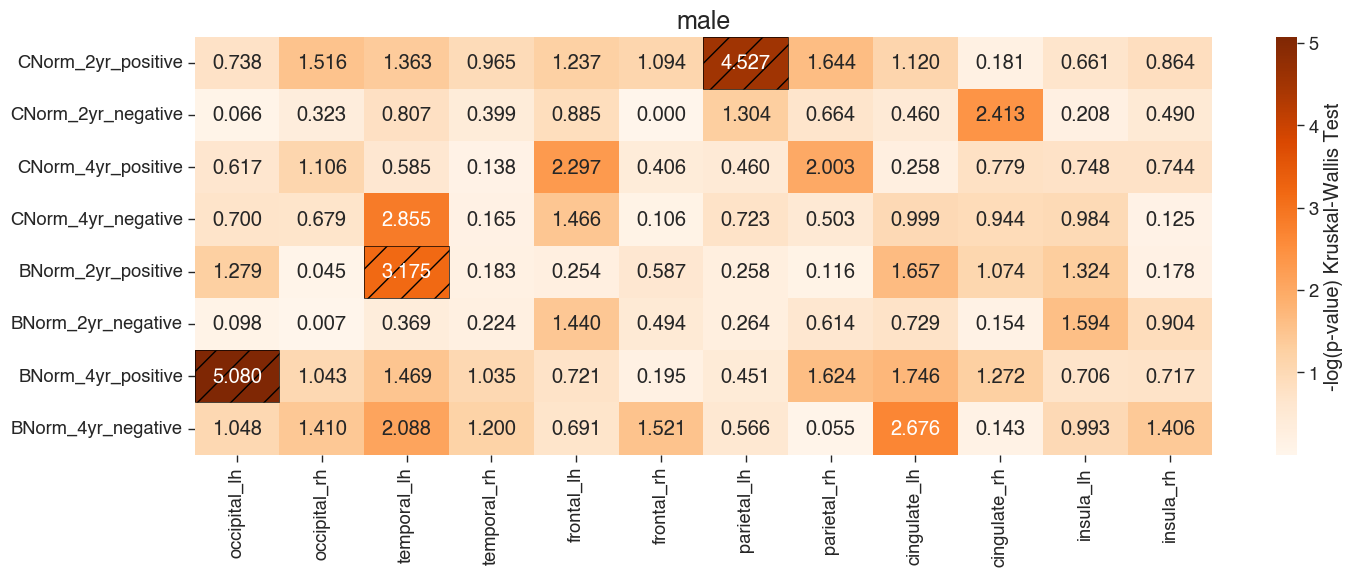

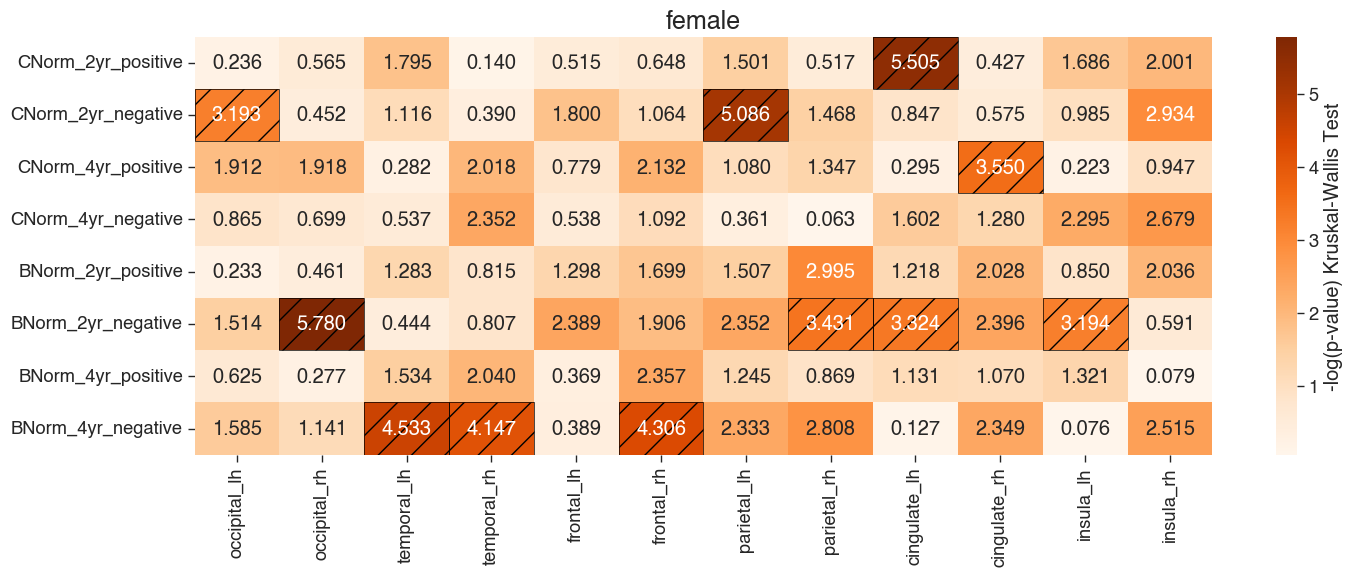

In [24]:
from matplotlib.patches import Rectangle

group_test_wo_other = group_test[group_test.lobe!="other"].copy()
group_test_wo_other['x'] = group_test_wo_other[['lobe', 'hemisphere']].agg('_'.join, axis=1)
group_test_wo_other['y'] = group_test_wo_other[['model', 'timepoint', 'deviator']].agg('_'.join, axis=1)

for sex in group_test_wo_other.sex.unique():
    fig, axes=plt.subplots(figsize=(15, 6))
    this = group_test_wo_other[group_test_wo_other.sex==sex]
    pvals = {}
    dfs = []
    
    for y in group_test_wo_other.y.unique():
        #print(y)
        for x in group_test_wo_other.x.unique():
            pvals[x] = this[(this.y==y) & (this.x==x)].pval.values
        df_pvals = pd.DataFrame(pvals)
        df_pvals['y'] = y
        dfs.append(df_pvals)
        
    df = pd.concat(dfs, axis=0)
    df.iloc[:, :-1] = -np.log(df.iloc[:, :-1])
    df.set_index('y', inplace=True)
    sns.heatmap(df, ax=axes, annot=True, fmt=".3f", cmap='Oranges', cbar_kws={'label': '-log(p-value) Kruskal-Wallis Test'})
    axes.set_title(sex, fontsize=18)
    axes.set_ylabel('')
    idcs = np.where(~df[df>-np.log(0.05)].isna())
    
    for i in range(len(idcs[0])):
        axes.add_patch(Rectangle((idcs[1][i], idcs[0][i]), 1, 1, fill=False, edgecolor='black', lw=.5,
                             hatch="/"))
    
    fig.tight_layout()
    plt.savefig(os.path.join(plot_out_dir, f'{sex}_kw-heatmaps.pdf'), transparent=False, dpi=300)

In [25]:
def compute_whole_brain_deviators(data, out_dir, outprefix, thresh=1.96):
    '''
    This function computes counts and percentages of deviating regions >per subject<!
    '''
    
    dfs_count, dfs_prct = [], [] 
    
    for tpt in data.timepoint.unique():
        df_count = pd.DataFrame(columns=[f"positive_{tpt}", f"negative_{tpt}"])
        df_prct = pd.DataFrame(columns=[f"positive_{tpt}", f"negative_{tpt}"])
        this_data = data[data.timepoint == tpt]
        
        for i in range(len(this_data)):
            count_pos, count_neg = np.sum(this_data.iloc[i, :-3]>thresh), np.sum(this_data.iloc[i, :-3]<-thresh)
            prct_pos, prct_neg = count_pos/len(this_data.iloc[i, :-3]), count_neg/len(this_data.iloc[i, :-3])
            df_count.loc[i] = [count_pos, count_neg]
            df_prct.loc[i] = [prct_pos, prct_neg]
        
        dfs_count.append(df_count)
        dfs_prct.append(df_prct)
        
    data_merge = pd.concat(dfs_count, axis=1)
    out_name = os.path.join(out_dir, f'{outprefix}_count-deviators_thresh-{thresh}.csv')
    data_merge.to_csv(out_name, index=False)

    data_merge = pd.concat(dfs_prct, axis=1)
    out_name = os.path.join(out_dir, f'{outprefix}_prct-deviators_thresh-{thresh}.csv')
    data_merge.to_csv(out_name, index=False)


In [26]:
def compute_percent_deviators(data, out_dir, outprefix, thresh=1.96):
    '''
    This function computes the number and percentage of deviators >per region<!
    '''
    timepoints = ["2yr", "4yr"]
            
    dfs_prct, dfs_count = [], []
    ctr=0
    
    for tpt in timepoints:
        
        df_prct = pd.DataFrame(columns=['ROI', f'positive_{tpt}', f'negative_{tpt}'])
        df_count = df_prct.copy()
        prct_pos, prct_neg, count_pos, count_neg = 0, 0, 0, 0 
        
        for r, roi in enumerate(ROI_lbls):
            
            roi_z = data[(data.timepoint==tpt)][roi].values
            count_pos, count_neg = np.sum(roi_z > thresh), np.sum(roi_z < -thresh)
            prct_pos, prct_neg = (count_pos/len(roi_z))*100, (count_neg/len(roi_z))*100
            
            df_count.loc[ctr] = [roi, count_pos, count_neg]
            df_prct.loc[ctr] = [roi, prct_pos, prct_neg]
            ctr+=1

        dfs_prct.append(df_prct)
        dfs_count.append(df_count)
        
    data_merge = reduce(lambda left, right: pd.merge(left, right, on = ["ROI"], how = "inner"), dfs_prct)
    out_name = os.path.join(out_dir, f'{outprefix}_prct-deviators_thresh-{thresh}.csv')
    data_merge.to_csv(out_name, index=False)

    data_merge = reduce(lambda left, right: pd.merge(left, right, on = ["ROI"], how = "inner"), dfs_count)
    out_name = os.path.join(out_dir, f'{outprefix}_count-deviators_thresh-{thresh}.csv')
    data_merge.to_csv(out_name, index=False)


In [27]:
# get counts and percentage deviators for the male and female models
for ds in ['male', 'female']:
    for mID in MODEL_IDS:
        # load the z-score values
        data = pd.read_csv(os.path.join(stats_out_dir, mID, ds, f'all_z.csv'))
        data[["lh_avg", "rh_avg"]] = 0 # we do not want to track the averages, so set them to 0
        
        out_dir = os.path.join(stats_out_dir, mID, ds)
        
        if ds == 'full': # we should separate the sexes in the full model condition
            for s, sex in enumerate(['male', 'female']):
                sex_data = data[data.sex==sex]
                compute_percent_deviators(sex_data, out_dir, f"{sex}_across-subjects")
                compute_whole_brain_deviators(sex_data, out_dir, f"{sex}_wholebrain")
                
        else:
            compute_percent_deviators(data, out_dir, "across-subjects")
            compute_whole_brain_deviators(data, out_dir, "wholebrain")

### Association of deviation counts/percentages with PDS scores

CNorm male 2yr positive -0.5226085281412625 0.6015115423535166
CNorm male 2yr negative -0.794797935297609 0.4271624875814869
CNorm male 4yr positive -0.4479824451851083 0.6543878714855207
CNorm male 4yr negative -1.9036612514990767 0.057610970538225614
CNorm female 2yr positive -2.60164593089781 0.009656396198563889
CNorm female 2yr negative 1.0116107697737502 0.31239615645679275
CNorm female 4yr positive -2.0590541000940625 0.04020002674966311
CNorm female 4yr negative 0.6205366305135693 0.5352928676168713
BNorm male 2yr positive -0.23127355446913928 0.8172105357544764
BNorm male 2yr negative -1.4719176458534171 0.14176289298115086
BNorm male 4yr positive -1.9206207352365752 0.05542994936953334
BNorm male 4yr negative -2.141792363248424 0.0327624212030956
BNorm female 2yr positive -1.968513793750478 0.04976737965382953
BNorm female 2yr negative 0.2625037332907214 0.7930816100131288
BNorm female 4yr positive -2.6016969882339924 0.00965498562925162
BNorm female 4yr negative -0.085167187

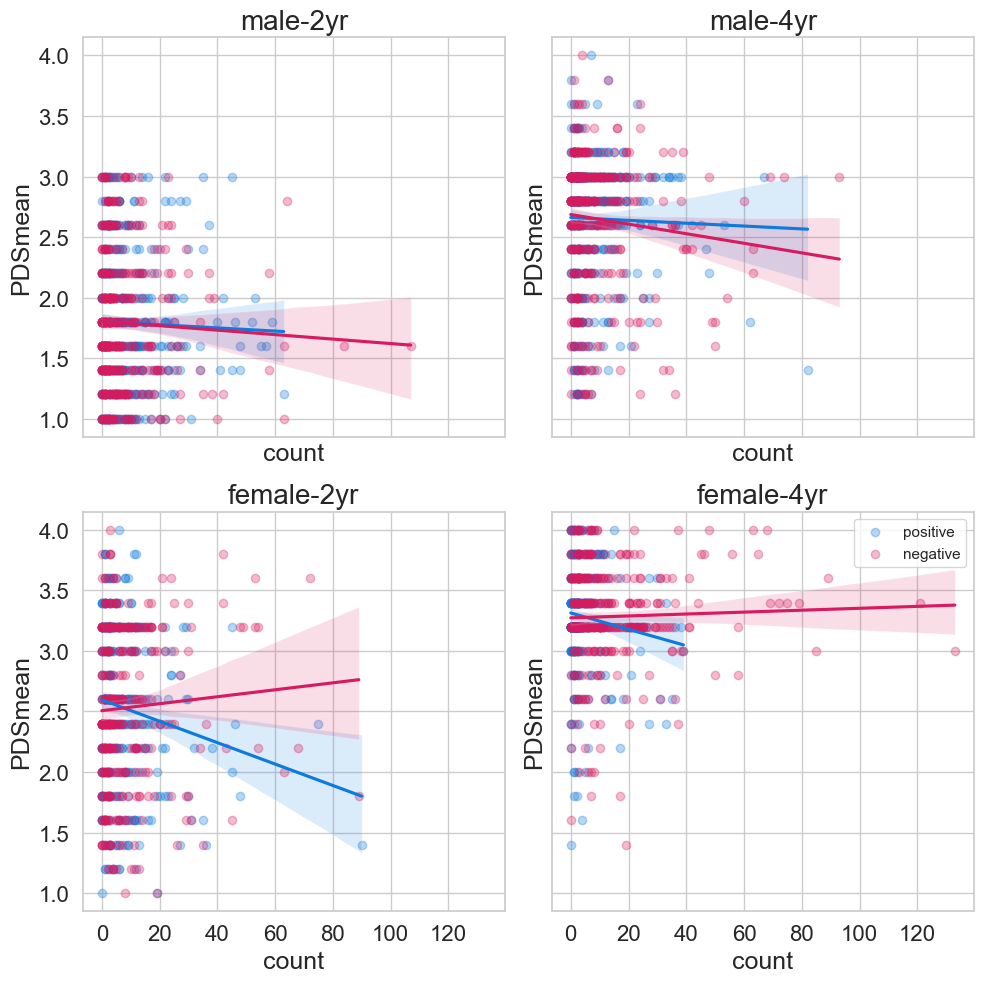

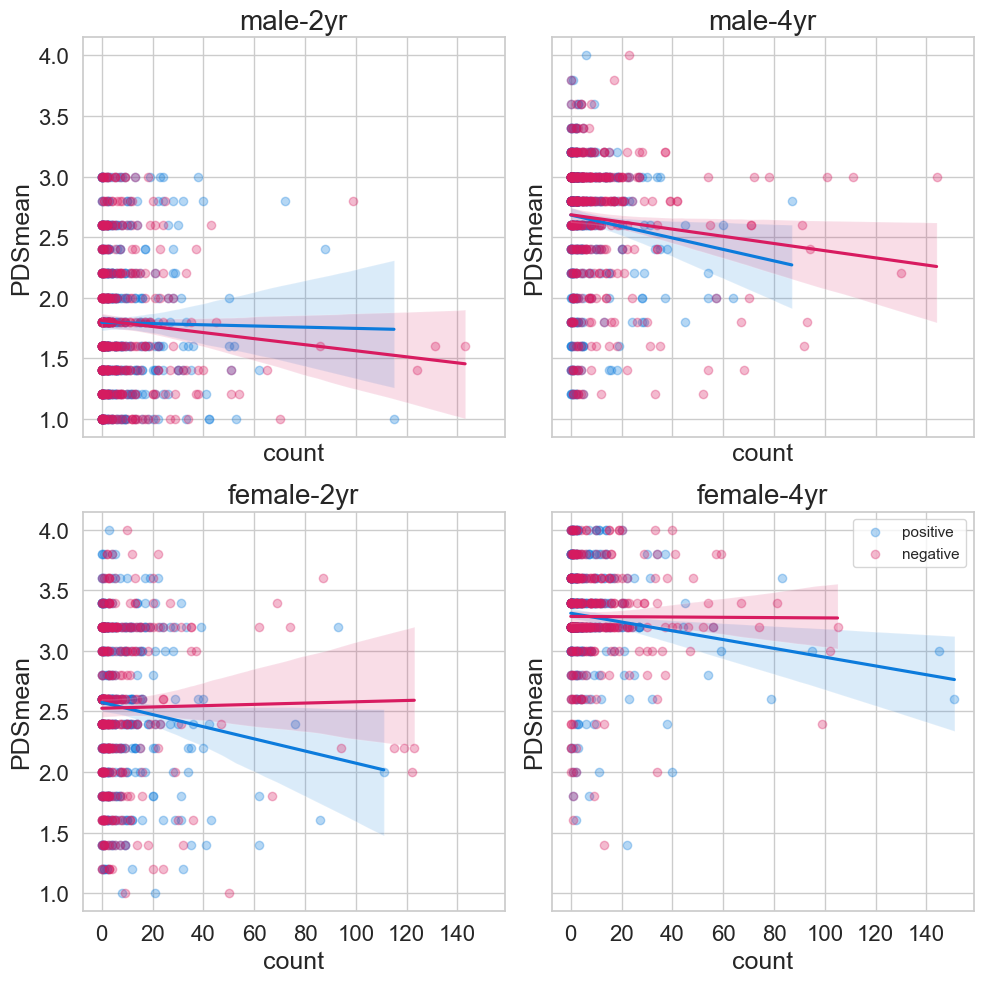

In [28]:
sns.set(style='whitegrid')
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16

# load the demographic data
df_demo_male = pd.read_csv("data/test_male_f2.csv", usecols=["src_subject_id", "sex_bl", "age_bl", "PDS_mean_p_bl", "PDS_mean_p_2yr", "PDS_mean_p_4yr"])
df_demo_female = pd.read_csv("data/test_female_f2.csv", usecols=["src_subject_id", "sex_bl", "age_bl", "PDS_mean_p_bl", "PDS_mean_p_2yr", "PDS_mean_p_4yr"])

sexes = ['male', 'female']

for m, mID in enumerate(MODEL_IDS):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    
    for s, sex in enumerate(sexes):
        df_prct_devs = pd.read_csv(f"stats/glasser/{mID}/{sex}/wholebrain_count-deviators_thresh-1.96.csv")
        #df_prct_devs = np.log(df_prct_devs).replace([np.inf, -np.inf], np.nan)
    
        dfs = []
        for t, tpt in enumerate(["2yr", "4yr"]):
            df = pd.DataFrame(columns=["t_pos", "p_pos", "t_neg", "p_neg", "timepoint"])
    
            to_plot = pd.concat([df_demo_male if s==0 else df_demo_female, df_prct_devs], axis=1)
    
            model_pos = ols(f"PDS_mean_p_{tpt} ~ positive_{tpt}", data=to_plot).fit()
            print(mID, sex, tpt, "positive", model_pos.tvalues.values[1], model_pos.pvalues.values[1])
            sns.regplot(ax=axes[s,t], data=to_plot, x=f"positive_{tpt}", y=f"PDS_mean_p_{tpt}", 
                        label="positive", scatter_kws={'alpha': .3}, color=colors[0])
            axes[s,t].set_xlabel('count', fontsize=18)
            axes[s,t].set_ylabel('PDSmean', fontsize=18)
            axes[s,t].set_title(f"{sex}-{tpt}", fontsize=20)
            
            model_neg = ols(f"PDS_mean_p_{tpt} ~ negative_{tpt}", data=to_plot).fit()
            print(mID, sex, tpt, "negative", model_neg.tvalues.values[1], model_neg.pvalues.values[1])
            sns.regplot(ax=axes[s,t], data=to_plot, x=f"negative_{tpt}", y=f"PDS_mean_p_{tpt}", 
                        label="negative", scatter_kws={'alpha': .3}, color=colors[1])
            axes[s,t].set_xlabel('count', fontsize=18)
            axes[s,t].set_ylabel('PDSmean', fontsize=18)
            axes[s,t].set_title(f"{sex}-{tpt}", fontsize=20)
            
    plt.legend()
    fig.tight_layout()
    plt.savefig(os.path.join(plot_out_dir, mID, "whole-brain_deviations.pdf"), transparent=False, dpi=300)

mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12
sns.set(style='white')
# critical p = 0.05/16 = 0.003125

In [29]:
from scipy.stats import chi2_contingency, chisquare, normaltest

In [30]:
# run a statistical test of B-Norm vs C-norm for the overall deviation percentages
# we have to make sure we use an appropriate test here, or we make sure that the values are normally distributed

thresh = 1.96
ds = 'male'
data_id = 'male'

#can be 
cols_of_interest = [["positive_2yr", "negative_2yr"], 
                    ["positive_4yr", "negative_4yr"]]

for c, coi in enumerate(cols_of_interest):
    contingency_mat = np.zeros((2,2))
    dfs = []

    print("\nDo stats for", coi, "\n")
    
    for m, mID in enumerate(MODEL_IDS):
        out_dir = os.path.join(stats_out_dir, mID, ds, f'across-subjects_count-deviators_thresh-{thresh}.csv')
        dfs.append(pd.read_csv(out_dir, usecols=["ROI", *coi]))
        print('test of normality for negative for', mID, normaltest(dfs[m][coi[1]].values))
        print('test of normality for positive for', mID, normaltest(dfs[m][coi[0]].values))
        contingency_mat[m, 0] = dfs[m].iloc[:, 1].sum()
        contingency_mat[m, 1] = dfs[m].iloc[:, 2].sum()
    
    dfs = pd.merge(dfs[0], dfs[1], on='ROI')
    
    # do the whole brain comparison (?)
    res = chi2_contingency(contingency_mat)
    print('statistic:', res.statistic, 'pval:', res.pvalue)
    print('expected:', res.expected_freq)
    
    # do the comparison between the models where each ROI is taken into account separately
    #positive
    idcs_wo_avg = (dfs.ROI!="lh_avg") & (dfs.ROI!="rh_avg")
    a = chi2_contingency(dfs[idcs_wo_avg].iloc[:, [1, 3]]);
    print('Positives - Statistic: ', a.statistic, 'p-val: ', a.pvalue)
    
    a = chi2_contingency(dfs[idcs_wo_avg].iloc[:, [2, 4]]);
    print('Negatives - Statistic: ', a.statistic, 'p-val: ', a.pvalue)


Do stats for ['positive_2yr', 'negative_2yr'] 

test of normality for negative for CNorm NormaltestResult(statistic=np.float64(11.387691099603666), pvalue=np.float64(0.003366621533439903))
test of normality for positive for CNorm NormaltestResult(statistic=np.float64(94.78122303880471), pvalue=np.float64(2.621313252151105e-21))
test of normality for negative for BNorm NormaltestResult(statistic=np.float64(1.012824729446435), pvalue=np.float64(0.6026538070874105))
test of normality for positive for BNorm NormaltestResult(statistic=np.float64(2.80058098420401), pvalue=np.float64(0.2465253398748195))
statistic: 12.321646167713961 pval: 0.00044773566969385446
expected: [[3717.76571148 3397.23428852]
 [3740.23428852 3417.76571148]]
Positives - Statistic:  367.100226405394 p-val:  0.37263205093462326
Negatives - Statistic:  356.6490526017092 p-val:  0.5251295389015355

Do stats for ['positive_4yr', 'negative_4yr'] 

test of normality for negative for CNorm NormaltestResult(statistic=np.floa

### Validating C-/B-Norms using percentile shifts (zDiff)

In [31]:
# define the different groups depending on the slope.
df_slope = []

for sex in ['male', 'female']:
    data = pd.read_csv(f"data/test_{sex}_f2.csv", usecols=["PDS_mean_p_2yr", "PDS_mean_p_4yr"])
    data['deltaPDS'] = data["PDS_mean_p_4yr"]-data["PDS_mean_p_2yr"]
    
    for mID in MODEL_IDS:
        y2yr = all_z[(all_z.sex==sex) & (all_z.timepoint=='2yr') & (all_z.model==mID)].reset_index(drop=True)
        y4yr = all_z[(all_z.sex==sex) & (all_z.timepoint=='4yr') & (all_z.model==mID)].reset_index(drop=True)

        df_rise = y4yr.iloc[:,:-3] - y2yr.iloc[:,:-3]
        df_rise = pd.concat([df_rise, data], axis=1)
        df_rise['subject'] = np.arange(len(df_rise))
        df_rise['sex'] = sex
        df_rise['model'] = mID
        df_slope.append(df_rise)

# assign a category to the participants within each ROI
# i.e., stable = 0, negative-deviator = 1, positive-deviator = 2
df_slope = pd.concat(df_slope, axis=0)
df_cats = df_slope.copy()
thresh = 1 # this is arbitrary. Need to discuss what a good threshold would be
for r, roi in enumerate(ROI_lbls):
    df_cats.loc[(df_cats[roi]>= -thresh) & (df_cats[roi]<= thresh), roi] = 0
    df_cats.loc[df_cats[roi]>thresh, roi] = 2
    df_cats.loc[df_cats[roi]<-thresh, roi] = 1
    df_cats[roi] = df_cats[roi].replace({0: 'stable', 1: 'negative', 2: 'positive'}) # make it human readable

df_cats.head(5)

lh_avg   lh_L_V1 lh_L_MST   lh_L_V6 lh_L_V2   lh_L_V3   lh_L_V4 lh_L_V8  \
0  stable  positive   stable    stable  stable    stable    stable  stable   
1  stable    stable   stable    stable  stable    stable    stable  stable   
2  stable    stable   stable    stable  stable    stable    stable  stable   
3  stable    stable   stable    stable  stable  negative  negative  stable   
4  stable    stable   stable  negative  stable    stable  negative  stable   

     lh_L_4 lh_L_3b  ... rh_R_TE1m rh_R_PI rh_R_a32pr rh_R_p24 PDS_mean_p_4yr  \
0    stable  stable  ...    stable  stable     stable   stable            2.4   
1    stable  stable  ...    stable  stable     stable   stable            2.8   
2    stable  stable  ...    stable  stable     stable   stable            2.8   
3  negative  stable  ...    stable  stable   negative   stable            3.0   
4  negative  stable  ...    stable  stable     stable   stable            3.0   

  PDS_mean_p_2yr deltaPDS subject   sex  model  
0            1.8      0.6       0  male  CNorm  
1            2.0      0.8       1  male  CNorm  
2            1.2      1.6       2  male  CNorm  
3            1.8      1.2       3  male  CNorm  
4            3.0      0.0       4  male  CNorm  

[5 rows x 368 columns]

Perform a Kruskal-Wallis test between the groups

In [32]:
from scipy.stats import kruskal

groups = ['stable', 'negative', 'positive']

dfs = []
df_kw_posthoc = pd.DataFrame(columns=["Roi", "sex", "model", "cat1", "cat2", "pval"])
for sex in ["male", "female"]:
    for model in MODEL_IDS:
        ctr = 0
        df_kruskal = pd.DataFrame(columns=["Roi", "sex", "model", "statistic", "pval"])
        
        for roi in ROI_lbls:
            deltas = df_cats[(df_cats.sex==sex) & (df_cats.model==model) & (df_cats.deltaPDS>0)][[roi, f"deltaPDS"]]
            vals = [deltas[deltas[roi]==i].iloc[:, 1].tolist() for i in groups]
            res = kruskal(*vals)
            df_kruskal.loc[ctr] = [roi, sex, model, res.statistic, res.pvalue]

            if res.pvalue<=0.05:
                dunns = sp.posthoc_dunn(vals, p_adjust = 'bonferroni')
                upper_right_entries = np.triu_indices(len(dunns), 1)
                adj_pvals = dunns.values[upper_right_entries[0], upper_right_entries[1]]
                ctr2 = 0
                for i in range(0, 2):
                    for j in range(i+1, 3):
                        print(roi, sex, model, groups[i], groups[j], adj_pvals[ctr2])
                        df_kw_posthoc.loc[len(df_kw_posthoc)] = [roi, sex, model, groups[i], groups[j], adj_pvals[ctr2]]
                        ctr2+=1

            ctr+=1
            
        print(len(df_kruskal[df_kruskal.pval<.05]))
        df_kruskal.loc[~df_kruskal.pval.isna(), "pcorr"] = multipletests(df_kruskal[~df_kruskal.pval.isna()]['pval'], method="fdr_bh")[1]
        dfs.append(df_kruskal)

df_stats = pd.concat(dfs, axis=0)
df_kw_posthoc.to_csv(os.path.join(stats_out_dir, "kw_slope_delta_posthoc.csv"), index=False)

lh_L_SFL male CNorm stable negative 0.008672854110422639
lh_L_SFL male CNorm stable positive 1.0
lh_L_SFL male CNorm negative positive 0.3877668342536022
lh_L_5L male CNorm stable negative 0.003985050840127868
lh_L_5L male CNorm stable positive 1.0
lh_L_5L male CNorm negative positive 0.4333291127550003
lh_L_47l male CNorm stable negative 0.05019568022078195
lh_L_47l male CNorm stable positive 0.7256844731525153
lh_L_47l male CNorm negative positive 1.0
lh_L_10pp male CNorm stable negative 0.027168052610855198
lh_L_10pp male CNorm stable positive 1.0
lh_L_10pp male CNorm negative positive 0.6094644274214314
lh_L_43 male CNorm stable negative 0.04680713742299864
lh_L_43 male CNorm stable positive 0.6464121690066291
lh_L_43 male CNorm negative positive 1.0
lh_L_PFcm male CNorm stable negative 0.01716932807695766
lh_L_PFcm male CNorm stable positive 1.0
lh_L_PFcm male CNorm negative positive 0.08395292277416129
lh_L_A4 male CNorm stable negative 1.0
lh_L_A4 male CNorm stable positive 0.03

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)


lh_L_PGp female CNorm stable negative 0.11523256632138446
lh_L_PGp female CNorm stable positive 0.459807869576389
lh_L_PGp female CNorm negative positive 1.0
lh_L_PHA2 female CNorm stable negative 0.0011411551917487033
lh_L_PHA2 female CNorm stable positive 1.0
lh_L_PHA2 female CNorm negative positive 0.15541011145040876
lh_L_VMV2 female CNorm stable negative 0.036551792719146214
lh_L_VMV2 female CNorm stable positive 1.0
lh_L_VMV2 female CNorm negative positive 1.0
lh_L_TGv female CNorm stable negative 0.011798091165914498
lh_L_TGv female CNorm stable positive 0.8882799926523298
lh_L_TGv female CNorm negative positive 0.9697246546383477


/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)


rh_R_d23ab female CNorm stable negative 0.13776868670538842
rh_R_d23ab female CNorm stable positive 0.208357995822411
rh_R_d23ab female CNorm negative positive 0.03536321824096078
rh_R_7PC female CNorm stable negative 0.1531428129235391
rh_R_7PC female CNorm stable positive 0.0865855694794091
rh_R_7PC female CNorm negative positive 0.5762169912717927


/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/3842505679.py:15: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*vals)


rh_R_TE1p female CNorm stable negative 0.1783544877709814
rh_R_TE1p female CNorm stable positive 0.30957131769162055
rh_R_TE1p female CNorm negative positive 1.0
rh_R_PFop female CNorm stable negative 0.38595076215909574
rh_R_PFop female CNorm stable positive 0.1514127901619091
rh_R_PFop female CNorm negative positive 0.03724811251232952
rh_R_V6A female CNorm stable negative 1.0
rh_R_V6A female CNorm stable positive 0.021822674969311187
rh_R_V6A female CNorm negative positive 0.015392022843428232
9
lh_L_p24pr female BNorm stable negative 0.8772251334851611
lh_L_p24pr female BNorm stable positive 0.002541109493680617
lh_L_p24pr female BNorm negative positive 0.1112663946784617
lh_L_9p female BNorm stable negative 1.0
lh_L_9p female BNorm stable positive 0.013264592533505223
lh_L_9p female BNorm negative positive 0.011406085392884019
lh_L_i6-8 female BNorm stable negative 0.6150515432585022
lh_L_i6-8 female BNorm stable positive 0.11240252644666274
lh_L_i6-8 female BNorm negative positiv

In [33]:
#df_stats[df_stats.pval<.05].to_csv("test.csv", index=False)
df_stats["logp"] = -np.log(df_stats.pval)
df_stats.to_csv(os.path.join(stats_out_dir, "kw_slope_delta.csv"), index=False)
df_stats[df_stats.pval<.05].to_csv(os.path.join(stats_out_dir, "kw_slope_delta_sig.csv"), index=False)
sig_areas = df_stats[df_stats["pval"]<0.05].copy()
sig_areas

Roi     sex  model  statistic      pval     pcorr      logp
26    lh_L_SFL    male  CNorm   8.952116  0.011378  0.593828  4.476058
39     lh_L_5L    male  CNorm  10.880907  0.004338  0.392545  5.440453
76    lh_L_47l    male  CNorm   6.989503  0.030356  0.612964  3.494752
90   lh_L_10pp    male  CNorm   7.330860  0.025593  0.612964  3.665430
99     lh_L_43    male  CNorm   7.273612  0.026336  0.612964  3.636806
..         ...     ...    ...        ...       ...       ...       ...
289  rh_R_FOP4  female  BNorm   7.124022  0.028382  0.795123  3.562011
293  rh_R_AAIC  female  BNorm   6.575378  0.037340  0.795123  3.287689
307  rh_R_PHA1  female  BNorm   7.094372  0.028806  0.795123  3.547186
324   rh_R_PGp  female  BNorm   6.082958  0.047764  0.897552  3.041479
333   rh_R_V6A  female  BNorm   7.703476  0.021243  0.795123  3.851738

[79 rows x 7 columns]

In [34]:
from statannotations.Annotator import Annotator

sns.set_theme(
    context='paper',
    style='ticks',
    palette='colorblind',
    font='helvetica',
    font_scale=1.5,
    color_codes=True,
    rc=None,
)

# I want to plot the mean PDS scores for the groups from significant ROIs
pairs = [("stable", "negative"), ("stable", "positive"), ("negative", "positive")]

order = ['negative', 'stable', 'positive']

r_df = df_cats[df_cats.deltaPDS>0].copy()

for idx, row in sig_areas.iterrows():
    to_plot = r_df[[row.Roi, "sex", "deltaPDS", "model"]]
    
    fig, ax = plt.subplots(figsize=(6,6))
    idcs = (to_plot.model==model) & (to_plot.sex==sex)
    sns.boxplot(ax=ax, data=to_plot[idcs], x=row.Roi, y='deltaPDS', order=order)
    sns.stripplot(ax=ax, data=to_plot[idcs], x=row.Roi, y='deltaPDS', order=order, color='black', legend=False, alpha=.5)
    ax.set_title(f"sex={row.sex} model={row.model}")
    ax.grid(linestyle="-", alpha=0.5, axis="y", zorder=1)
    
    annotator = Annotator(ax, pairs, data=to_plot[idcs], x=row.Roi, y='deltaPDS', order=order);
    #annotator.configure(test='Kruskal', text_format='star', loc='inside', verbose=0); # comparisons_correction="Bonferroni"
    annotator.configure(test=None, text_format='star', loc='inside', verbose=0); # comparisons_correction="Bonferroni"
    these_pvals = df_kw_posthoc[(df_kw_posthoc.sex==row.sex) & (df_kw_posthoc.Roi==row.Roi) & (df_kw_posthoc.model==row.model)].pval.values
    annotator.set_pvalues(pvalues=these_pvals)
    annotator.annotate();

    out_dir = os.path.join(plot_out_dir, row.model, row.sex, 'kw_slope_pds')
    os.makedirs(out_dir, exist_ok=True)
    plt.savefig(os.path.join(out_dir, f"{row.Roi}.pdf"), transparent=False, dpi=300)
    plt.close()

    #fig.tight_layout()

In [35]:
from scipy.stats import kruskal

groups = ['stable', 'negative', 'positive']

dfs = []
df_kw_posthoc = pd.DataFrame(columns=["Roi", "sex", "model", "timepoint", "cat1", "cat2", "pval"])
for sex in ["male", "female"]:
    for model in MODEL_IDS:
        for tpt in ["2yr", "4yr"]:
            ctr = 0
            df_kruskal = pd.DataFrame(columns=["Roi", "sex", "model", "timepoint", "statistic", "pval"])
            
            for roi in ROI_lbls:
                # get PDS at tpt for a given ROI (associated with group)
                roi_grp_pds = df_cats[(df_cats.sex==sex) & (df_cats.model==model)][[roi, f"PDS_mean_p_{tpt}"]]
                for_kw = [roi_grp_pds[roi_grp_pds[roi]==i].iloc[:, 1].tolist() for i in groups]
                res = kruskal(*for_kw)
                df_kruskal.loc[ctr] = [roi, sex, model, tpt, res.statistic, res.pvalue]

                if res.pvalue<=0.05:
                    dunns = sp.posthoc_dunn(for_kw, p_adjust = 'bonferroni')
                    upper_right_entries = np.triu_indices(len(dunns), 1)
                    adj_pvals = dunns.values[upper_right_entries[0], upper_right_entries[1]]
                    ctr2 = 0
                    for i in range(0, 2):
                        for j in range(i+1, 3):
                            print(roi, sex, model, tpt, groups[i], groups[j], adj_pvals[ctr2])
                            df_kw_posthoc.loc[len(df_kw_posthoc)] = [roi, sex, model, tpt, groups[i], groups[j], adj_pvals[ctr2]]
                            ctr2+=1

                ctr+=1
                
            print(len(df_kruskal[df_kruskal.pval<.05]))
            df_kruskal["pcorr"] = multipletests(df_kruskal['pval'], method="fdr_bh")[1]
            dfs.append(df_kruskal)

df_stats = pd.concat(dfs, axis=0)
df_kw_posthoc.to_csv(os.path.join(stats_out_dir, "kw_slope_posthoc.csv"), index=False)

lh_L_FEF male CNorm 2yr stable negative 1.0
lh_L_FEF male CNorm 2yr stable positive 0.02754244471434713
lh_L_FEF male CNorm 2yr negative positive 0.017397488794463845
lh_L_23d male CNorm 2yr stable negative 0.05389347072319502
lh_L_23d male CNorm 2yr stable positive 1.0
lh_L_23d male CNorm 2yr negative positive 1.0
lh_L_MIP male CNorm 2yr stable negative 1.0
lh_L_MIP male CNorm 2yr stable positive 0.03693428863380536
lh_L_MIP male CNorm 2yr negative positive 0.25037577941903294
lh_L_a24pr male CNorm 2yr stable negative 0.7064703522265642
lh_L_a24pr male CNorm 2yr stable positive 0.06717119192149808
lh_L_a24pr male CNorm 2yr negative positive 0.5515091096725165
lh_L_47m male CNorm 2yr stable negative 0.005595407007303646
lh_L_47m male CNorm 2yr stable positive 1.0
lh_L_47m male CNorm 2yr negative positive 0.0895230557750041
lh_L_8Ad male CNorm 2yr stable negative 0.4066160955902469
lh_L_8Ad male CNorm 2yr stable positive 0.012690378680295869
lh_L_8Ad male CNorm 2yr negative positive 0.3

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)


rh_R_V3 female CNorm 2yr stable negative 0.2826412570141968
rh_R_V3 female CNorm 2yr stable positive 0.024571533331254253
rh_R_V3 female CNorm 2yr negative positive 0.768712153781248
rh_R_4 female CNorm 2yr stable negative 0.28715527503755456
rh_R_4 female CNorm 2yr stable positive 0.11413135597864263
rh_R_4 female CNorm 2yr negative positive 0.021144954626022998
rh_R_FEF female CNorm 2yr stable negative 1.0
rh_R_FEF female CNorm 2yr stable positive 0.05819615535723692
rh_R_FEF female CNorm 2yr negative positive 0.05338147323109245
rh_R_7Pm female CNorm 2yr stable negative 0.03769693977906538
rh_R_7Pm female CNorm 2yr stable positive 0.7393395435796553
rh_R_7Pm female CNorm 2yr negative positive 0.022408241477842865
rh_R_POS1 female CNorm 2yr stable negative 0.1846338202942157
rh_R_POS1 female CNorm 2yr stable positive 0.07474715469178222
rh_R_POS1 female CNorm 2yr negative positive 0.882823625461702
rh_R_d23ab female CNorm 2yr stable negative 0.09835896175829348
rh_R_d23ab female CNor

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*

rh_R_VVC female CNorm 2yr stable negative 0.05762243757109925
rh_R_VVC female CNorm 2yr stable positive 0.8970393373576251
rh_R_VVC female CNorm 2yr negative positive 1.0
21
lh_L_5mv female CNorm 4yr stable negative 1.0
lh_L_5mv female CNorm 4yr stable positive 0.0006896119372902911
lh_L_5mv female CNorm 4yr negative positive 0.004574920635208834
lh_L_p24pr female CNorm 4yr stable negative 0.4674113709119819
lh_L_p24pr female CNorm 4yr stable positive 0.047682142195663274
lh_L_p24pr female CNorm 4yr negative positive 0.41014178258585715
lh_L_9m female CNorm 4yr stable negative 0.039159952022386604
lh_L_9m female CNorm 4yr stable positive 1.0
lh_L_9m female CNorm 4yr negative positive 1.0
lh_L_FOP2 female CNorm 4yr stable negative 1.0
lh_L_FOP2 female CNorm 4yr stable positive 0.018185792416507543
lh_L_FOP2 female CNorm 4yr negative positive 0.07294486198840591
lh_L_PBelt female CNorm 4yr stable negative 0.3958417748436581
lh_L_PBelt female CNorm 4yr stable positive 0.10489473561878361


/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)


lh_L_MBelt female CNorm 4yr stable negative 1.0
lh_L_MBelt female CNorm 4yr stable positive 0.015906435766185324
lh_L_MBelt female CNorm 4yr negative positive 0.08887414750489221
rh_R_V3 female CNorm 4yr stable negative 0.5469213403482845
rh_R_V3 female CNorm 4yr stable positive 0.08679394836952206
rh_R_V3 female CNorm 4yr negative positive 0.9999257771119621
rh_R_7m female CNorm 4yr stable negative 1.0
rh_R_7m female CNorm 4yr stable positive 0.05560001417341375
rh_R_7m female CNorm 4yr negative positive 0.5767139791191417
rh_R_5mv female CNorm 4yr stable negative 1.0
rh_R_5mv female CNorm 4yr stable positive 0.03828112529826938
rh_R_5mv female CNorm 4yr negative positive 0.09520051924847031
rh_R_7PL female CNorm 4yr stable negative 0.10541276779961191
rh_R_7PL female CNorm 4yr stable positive 0.34080558970573405
rh_R_7PL female CNorm 4yr negative positive 0.038696649153608216
rh_R_6mp female CNorm 4yr stable negative 0.28823307991440983
rh_R_6mp female CNorm 4yr stable positive 0.120

/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*for_kw)
/var/folders/f9/sy1dpwfx5vx_30_pgdqd5jmm0000gn/T/ipykernel_59749/1456543521.py:17: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = kruskal(*

rh_R_FOP5 female CNorm 4yr stable negative 1.0
rh_R_FOP5 female CNorm 4yr stable positive 0.0030231122564211535
rh_R_FOP5 female CNorm 4yr negative positive 0.009211456085264587
22
lh_L_LO1 female BNorm 2yr stable negative 0.12932143855185166
lh_L_LO1 female BNorm 2yr stable positive 0.6951236343547856
lh_L_LO1 female BNorm 2yr negative positive 0.03662048714067877
lh_L_p24pr female BNorm 2yr stable negative 1.0
lh_L_p24pr female BNorm 2yr stable positive 0.001075563571636479
lh_L_p24pr female BNorm 2yr negative positive 0.04549183151865884
lh_L_8BL female BNorm 2yr stable negative 0.8780342860829443
lh_L_8BL female BNorm 2yr stable positive 0.035456645841030615
lh_L_8BL female BNorm 2yr negative positive 0.41313865255265186
lh_L_IFJp female BNorm 2yr stable negative 1.0
lh_L_IFJp female BNorm 2yr stable positive 0.01639972231206776
lh_L_IFJp female BNorm 2yr negative positive 0.10303398017983927
lh_L_FOP4 female BNorm 2yr stable negative 0.3836529026549266
lh_L_FOP4 female BNorm 2yr s

In [36]:
df_stats["logp"] = -np.log(df_stats.pval)
df_stats.to_csv(os.path.join(stats_out_dir, "kw_slope.csv"), index=False)
df_stats[df_stats.pval<.05].to_csv(os.path.join(stats_out_dir, "kw_slope_sig.csv"), index=False)
sig_areas = df_stats[df_stats["pval"]<0.05].copy()
sig_areas

Roi     sex  model timepoint  statistic      pval     pcorr  \
10     lh_L_FEF    male  CNorm       2yr   7.793601  0.020307  0.787827   
32     lh_L_23d    male  CNorm       2yr   6.110795  0.047104  0.787827   
50     lh_L_MIP    male  CNorm       2yr   6.278131  0.043323  0.787827   
59   lh_L_a24pr    male  CNorm       2yr   6.562184  0.037587  0.787827   
66     lh_L_47m    male  CNorm       2yr   9.678550  0.007913  0.787827   
..          ...     ...    ...       ...        ...       ...       ...   
347   rh_R_pOFC  female  BNorm       4yr   9.573932  0.008338  0.140808   
350   rh_R_FOP5  female  BNorm       4yr   9.615687  0.008165  0.140808   
352   rh_R_p47r  female  BNorm       4yr   7.392036  0.024822  0.260310   
354  rh_R_MBelt  female  BNorm       4yr   6.151207  0.046162  0.344651   
360  rh_R_a32pr  female  BNorm       4yr  10.685990  0.004782  0.135616   

         logp  
10   3.896800  
32   3.055398  
50   3.139066  
59   3.281092  
66   4.839275  
..        ...  
347  4.786966  
350  4.807844  
352  3.696018  
354  3.075603  
360  5.342995  

[246 rows x 8 columns]